## Definition of imports, functions etc

In [1]:
# general imports
import os, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [25, 15]
plt.rcParams.update({'font.size': 18})

In [160]:
# ml imports
import time
from sklearn.linear_model import LogisticRegression
import sklearn.model_selection as model_selection
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, plot_roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.preprocessing import StandardScaler
# models
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix as cv

In [3]:
# function to load data from multiple input files
def load_dataframe_from_files(dirin, fileprefix):
    import glob
    files = glob.glob(os.path.join(dirin, fileprefix))
    print("[Info] Loading {} files wt prefix:\n{}".format(len(files), fileprefix))
    df = pd.read_csv(files[0], comment='#', index_col=False)
    for file in files[1:]:
        print(".", end='')
        dftmp = pd.read_csv(file, comment='#', index_col=False)
        df = pd.concat([df, dftmp])
    print("")
    return df

In [4]:
# function to compute the std deviation of active slices based on NPE
def stddev_idslices_fun(row):
    # given an array of aquisitions, it return the std of activated slices
    # it create a populaion of slice ids, and compute stddev on them
    id_population = [item for id_list in [[i] * int(row.iloc[i]) for i in range(len(row))] for item in id_list]
    if id_population:    # check if the list of slice ids is not empty
        return np.std(id_population)
    else:
        return -1

In [5]:
# function to produce quadrant-based features in a parametric way
def produce_quadrant_features(df, nslices=72, nshiftings=4, quadrant_width=36):
    # split aquisitions in K "shifted" quadrant
    # by construction, there are 72 slices
    # we set quadrant_width = nslices // 2 because 
    # we know that the spread is within 15 slices
    shift = nslices // nshiftings   # derived
    assert(len(df.columns) == nslices)
    # create quadrants
    df_quadrants = []
    for i_shift in range(nshiftings):
        assert(i_shift*shift < nslices)
        quadrant = df.iloc[:, i_shift*shift:i_shift*shift + quadrant_width]
        if i_shift*shift + quadrant_width >= nslices:
            quadrant = pd.concat([quadrant, df.iloc[:, :i_shift*shift + quadrant_width - nslices]], axis=1)
        df_quadrants.append(quadrant)
    # compute stddev and meanPE for each quadrant
    for quadrant in df_quadrants:
        quadrant["stdslices"] = quadrant.apply(stddev_idslices_fun, axis=1)
        quadrant["meanpe"] = quadrant.apply(lambda row: row[:quadrant_width].mean(), axis=1)
    # aggregate the features in a single dataset
    features = pd.DataFrame()
    for i, quadrant in enumerate(df_quadrants):
        features = pd.concat([features, quadrant[["stdslices", "meanpe"]]], axis=1)
    features.columns = ["{}_{}".format(col, j) for j in range(len(df_quadrants)) for col in ["stdslices", "meanpe"]]
    return features

In [6]:
# function to produce quad-based features for multiple configurations
def produce_datasets_for_various_quandrant_features(muon_data, ar39_data, nshiftings, widths):
    muon_datasets, ar39_1_datasets = [], []
    for nshifting, width in zip(nshiftings, widths):
        muon_datasets.append(produce_quadrant_features(muon_data, nshiftings=nshifting, quadrant_width=width))
        print("[Info] Computed quadrant features wt nshifting={}, width={} for Muons".format(nshifting, width))
        ar39_1_datasets.append(produce_quadrant_features(ar39_data, nshiftings=nshifting, quadrant_width=width))
        print("[Info] Computed quadrant features wt nshifting={}, width={} for Ar39".format(nshifting, width))
    return muon_datasets, ar39_1_datasets

In [20]:
def augment_muons_by_roll(muon_df, augmentation_factor=1, skip_first_cols=2, nslices=72):
    X = muon_df.iloc[:, skip_first_cols:skip_first_cols+nslices].to_numpy()
    for roll in np.array(np.linspace(0, 72, augmentation_factor+1)[:-1], dtype='int'):
        if roll==0:
            XX = X
        else:
            XX = np.concatenate([XX, np.roll(X, roll, axis=1)])
    return pd.DataFrame(XX)

In [197]:
def undersample_argon(ar39_df, number_of_instances=1000, augment_from_pe=35, augmentation_nr=5,
                      skip_first_cols=2, nslices=72):
    bins = np.linspace(0, 61, 62)
    bin_cont, bin_edges, _ = plt.hist(ar39_df.pedetected, bins=bins, density=True, label="1Ar39", edgecolor='w')
    # compute the nr of samples for each PE value,
    # to undersample ar39 keeping the same distribution
    avail_instances_per_pe = np.array([len(ar39_df[ar39_df.pedetected==pe]) for pe in range(61)])
    nr_ar_samples_per_pe = np.array(np.where(np.ceil(bin_cont*number_of_instances)<=avail_instances_per_pe, np.ceil(bin_cont*number_of_instances), 0), dtype=int)
    # Introduce a small bias on instances with "high" PE value
    # to avoid to have just a few samples (e.g. 30,40,50,60 PE)
    scaled_ar39 = pd.DataFrame()
    for pe in range(1, 61):
        if pe > augment_from_pe:
            nr_instances = augmentation_nr
        else:
            nr_instances = nr_ar_samples_per_pe[pe]
        scaled_ar39 = pd.concat([scaled_ar39, ar39_cut_train[ar39_cut_train.pedetected==pe].iloc[:nr_instances]])
    AA = scaled_ar39.iloc[:, skip_first_cols:skip_first_cols+nslices].to_numpy()
    np.random.shuffle(AA)    # to avoid order by PE
    return pd.DataFrame(AA)

In [11]:
# loss - weighted f1 score
def loss(y_true, y_pred):
    tn, fp, fn, tp = cv(y_true, y_pred).ravel()
    w = 1    # if w=1 it is F1 score
    recall = tp / (tp + fn)
    w_precision = tp / (tp + w * fp)
    return 2 * (w_precision * recall) / (w_precision + recall)

In [138]:
# function to run Kfold X-validation on dtree by varying the parameters
# for each given datasets (differnt kind of features), it runs all this stuff
# and return the best model for each dataset
def run_multifeatures_xvalidation(muon_datasets, ar39_1_datasets, max_depth_lim=50, plot_flag=True, rndseed=666):
    data_template    = "[Info] Dataset with {} features"
    model_template   = "[Info] Model: {}, Hyperparams: {}"
    result_template  = "[Result] {}: Accuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1: {:.3f}\n"

    max_depth_param_list = np.linspace(1, max_depth_lim, max_depth_lim)   # try to set max-depth of Dtree (hyperparam)
    bestmodel_per_dataset = []
    score_bestmodel_per_dataset = []
    for i, (muon_features, ar39_1_features) in enumerate(zip(muon_datasets, ar39_1_datasets)):
        print(data_template.format(len(muon_features.columns)))
        # Prepare data for training
        muon_features["y"] = 1
        ar39_1_features["y"] = 0
        # data preparation
        data = pd.concat([muon_features, ar39_1_features], axis=0)
        X, y = data.iloc[:, :-1], data.iloc[:, -1]
        X = np.array(X)
        y = np.array(y)

        # K-Fold X-validation
        n_folds = 4    # each time 75% training, 25% validation
        kf = KFold(n_splits=n_folds, shuffle=True, random_state=rndseed)

        avg_accuracies = []
        avg_precisions = []
        avg_recalls = []
        avg_f1 = []    # F1 is our loss
        best_f1 = -1
        best_model = None
        best_j = -1
        for j, max_depth in enumerate(max_depth_param_list):
            clf = DecisionTreeClassifier(max_depth=max_depth, criterion="entropy")
            #print(model_template.format("DTree", max_depth))
            print(".", end="")
            start = time.time()
            # iterate over folds
            accuracies, precisions, recalls, f1s= [], [], [], []
            iteration = 0
            for train_ids, val_ids in kf.split(X):
                iteration = iteration + 1
                X_train, X_val = X[train_ids], X[val_ids]
                y_train, y_val = y[train_ids], y[val_ids]
                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_val)
                accuracies.append(accuracy_score(y_val, y_pred))
                precisions.append(precision_score(y_val, y_pred))
                recalls.append(recall_score(y_val, y_pred))
                f1s.append(loss(y_val, y_pred))
            avg_accuracies.append(np.mean(accuracies))
            avg_precisions.append(np.mean(precisions))
            avg_recalls.append(np.mean(recalls))
            avg_f1.append(np.mean(f1s))
            # Update best model
            if np.mean(f1s) > best_f1:
                best_model = clf
                best_j = j
                best_f1 = np.mean(f1s)
        if plot_flag:
            plt.plot(max_depth_param_list, avg_f1, label="F1 Score - Features {},{}".format(nshiftings[i], widths[i]))
            plt.scatter(max_depth_param_list[best_j], avg_f1[best_j])

        print("")
        print("[Result] The Best DTree has depth: {}".format(best_model.get_depth()))
        print(result_template.format("Validation Set", avg_accuracies[best_j], 
                                     avg_precisions[best_j], 
                                     avg_recalls[best_j], 
                                     avg_f1[best_j]))
        bestmodel_per_dataset.append(best_model)
        score_bestmodel_per_dataset.append({"accuracy": avg_accuracies[best_j],
                                           "precision": avg_precisions[best_j],
                                           "recall": avg_recalls[best_j],
                                           "f1": avg_f1[best_j]})
    if plot_flag:
        plt.legend()
        plt.xlabel("Max Depth of DTree (Hyperparam)")
        plt.ylabel("Score in 0,1")
        plt.title("Average F1 Score on Validation data - Tune DTree Depth")
        plt.show()
    return bestmodel_per_dataset, score_bestmodel_per_dataset

In [157]:
# function to run Kfold X-validation on dtree by varying the parameters
# for each given datasets (differnt kind of features), it runs all this stuff
# and return the best model for each dataset
def run_multifeatures_xvalidation_adaboost(muon_datasets, ar39_1_datasets, plot_flag=True, rndseed=666):
    data_template    = "[Info] Dataset with {} features"
    model_template   = "[Info] Model: AdaBoost DTree"
    result_template  = "[Result] {}: Accuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1: {:.3f}\n"

    bestmodel_per_dataset = []
    score_bestmodel_per_dataset = []
    for i, (muon_features, ar39_1_features) in enumerate(zip(muon_datasets, ar39_1_datasets)):
        print(data_template.format(len(muon_features.columns)))
        # Prepare data for training
        muon_features["y"] = 1
        ar39_1_features["y"] = 0
        # data preparation
        data = pd.concat([muon_features, ar39_1_features], axis=0)
        X, y = data.iloc[:, :-1], data.iloc[:, -1]
        X = np.array(X)
        y = np.array(y)

        # K-Fold X-validation
        n_folds = 4    # each time 75% training, 25% validation
        kf = KFold(n_splits=n_folds, shuffle=True, random_state=rndseed)

        avg_accuracies = []
        avg_precisions = []
        avg_recalls = []
        avg_f1 = []    # F1 is our loss
        best_f1 = -1
        best_model = None
        best_j = -1
        for j, max_depth in enumerate([0]):
            clf = AdaBoostClassifier(base_estimator=None, n_estimators=5)
            print(model_template)
            print(".", end="")
            start = time.time()
            # iterate over folds
            accuracies, precisions, recalls, f1s= [], [], [], []
            iteration = 0
            for train_ids, val_ids in kf.split(X):
                iteration = iteration + 1
                X_train, X_val = X[train_ids], X[val_ids]
                y_train, y_val = y[train_ids], y[val_ids]
                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_val)
                accuracies.append(accuracy_score(y_val, y_pred))
                precisions.append(precision_score(y_val, y_pred))
                recalls.append(recall_score(y_val, y_pred))
                f1s.append(loss(y_val, y_pred))
            avg_accuracies.append(np.mean(accuracies))
            avg_precisions.append(np.mean(precisions))
            avg_recalls.append(np.mean(recalls))
            avg_f1.append(np.mean(f1s))
            # Update best model
            if np.mean(f1s) > best_f1:
                best_model = clf
                best_j = j
                best_f1 = np.mean(f1s)
        if plot_flag:
            plt.plot(max_depth_param_list, avg_f1, label="F1 Score - Features {},{}".format(nshiftings[i], widths[i]))
            plt.scatter(max_depth_param_list[best_j], avg_f1[best_j])

        print("")
        print("[Result] The Best Ada-Ensemble has depth: {}".format(None))
        print(result_template.format("Validation Set", avg_accuracies[best_j], 
                                     avg_precisions[best_j], 
                                     avg_recalls[best_j], 
                                     avg_f1[best_j]))
        bestmodel_per_dataset.append(best_model)
        score_bestmodel_per_dataset.append({"accuracy": avg_accuracies[best_j],
                                           "precision": avg_precisions[best_j],
                                           "recall": avg_recalls[best_j],
                                           "f1": avg_f1[best_j]})
    if plot_flag:
        plt.legend()
        plt.xlabel("Hyperparam")
        plt.ylabel("Score in 0,1")
        plt.title("Average F1 Score on Validation data - Tune AdaBoost Params")
        plt.show()
    return bestmodel_per_dataset, score_bestmodel_per_dataset

In [162]:
# function to run Kfold X-validation on dtree by varying the parameters
# for each given datasets (differnt kind of features), it runs all this stuff
# and return the best model for each dataset
def run_multifeatures_xvalidation_gbt(muon_datasets, ar39_1_datasets, plot_flag=True, rndseed=666):
    data_template    = "[Info] Dataset with {} features"
    model_template   = "[Info] Model: Gradient Boosting Tree"
    result_template  = "[Result] {}: Accuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1: {:.3f}\n"

    bestmodel_per_dataset = []
    score_bestmodel_per_dataset = []
    for i, (muon_features, ar39_1_features) in enumerate(zip(muon_datasets, ar39_1_datasets)):
        print(data_template.format(len(muon_features.columns)))
        # Prepare data for training
        muon_features["y"] = 1
        ar39_1_features["y"] = 0
        # data preparation
        data = pd.concat([muon_features, ar39_1_features], axis=0)
        X, y = data.iloc[:, :-1], data.iloc[:, -1]
        X = np.array(X)
        y = np.array(y)

        # K-Fold X-validation
        n_folds = 4    # each time 75% training, 25% validation
        kf = KFold(n_splits=n_folds, shuffle=True, random_state=rndseed)

        avg_accuracies = []
        avg_precisions = []
        avg_recalls = []
        avg_f1 = []    # F1 is our loss
        best_f1 = -1
        best_model = None
        best_j = -1
        for j, max_depth in enumerate([0]):
            clf = GradientBoostingClassifier(random_state=0)
            #print(model_template.format("DTree", max_depth))
            print(".", end="")
            start = time.time()
            # iterate over folds
            accuracies, precisions, recalls, f1s= [], [], [], []
            iteration = 0
            for train_ids, val_ids in kf.split(X):
                iteration = iteration + 1
                X_train, X_val = X[train_ids], X[val_ids]
                y_train, y_val = y[train_ids], y[val_ids]
                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_val)
                accuracies.append(accuracy_score(y_val, y_pred))
                precisions.append(precision_score(y_val, y_pred))
                recalls.append(recall_score(y_val, y_pred))
                f1s.append(loss(y_val, y_pred))
            avg_accuracies.append(np.mean(accuracies))
            avg_precisions.append(np.mean(precisions))
            avg_recalls.append(np.mean(recalls))
            avg_f1.append(np.mean(f1s))
            # Update best model
            if np.mean(f1s) > best_f1:
                best_model = clf
                best_j = j
                best_f1 = np.mean(f1s)
        if plot_flag:
            plt.plot(max_depth_param_list, avg_f1, label="F1 Score - Features {},{}".format(nshiftings[i], widths[i]))
            plt.scatter(max_depth_param_list[best_j], avg_f1[best_j])

        print("")
        print("[Result] The Best GBTree has depth: {}".format(clf.get_params()["max_depth"]))
        print(result_template.format("Validation Set", avg_accuracies[best_j], 
                                     avg_precisions[best_j], 
                                     avg_recalls[best_j], 
                                     avg_f1[best_j]))
        bestmodel_per_dataset.append(best_model)
        score_bestmodel_per_dataset.append({"accuracy": avg_accuracies[best_j],
                                           "precision": avg_precisions[best_j],
                                           "recall": avg_recalls[best_j],
                                           "f1": avg_f1[best_j]})
    if plot_flag:
        plt.legend()
        plt.xlabel("Hyperparam")
        plt.ylabel("Score in 0,1")
        plt.title("Average F1 Score on Validation data - Tune GBTree Params")
        plt.show()
    return bestmodel_per_dataset, score_bestmodel_per_dataset

In [149]:
def plot_metrics_of_models(score_dict_per_model, model_names, title="Validation Score of Best Model for each Dataset"):
    best_accuracies, best_precisions, best_recalls, best_f1s = [], [], [], []
    feature_names = []
    for i, (nshifting, width) in enumerate(zip(nshiftings, widths)):
        feature_names.append("Features {}, {}".format(nshifting, width))
        scores = score_dict_per_model[i]
        best_accuracies.append(scores['accuracy'])
        best_precisions.append(scores['precision'])
        best_recalls.append(scores['recall'])
        best_f1s.append(scores['f1'])

    bar_width = 0.1
    plt.bar(np.arange(len(score_dict_per_model)) + 0*bar_width, best_accuracies, label="Accuracy", tick_label=model_names, width=bar_width)
    plt.bar(np.arange(len(score_dict_per_model)) + 1*bar_width, best_precisions, label="Precision", tick_label=model_names, width=bar_width)
    plt.bar(np.arange(len(score_dict_per_model)) + 2*bar_width, best_recalls, label="Recall", tick_label=model_names, width=bar_width)
    plt.bar(np.arange(len(score_dict_per_model)) + 3*bar_width, best_f1s, label="Loss F1", tick_label=model_names, width=bar_width)
    plt.title(title)
    plt.xlabel("Models")
    plt.ylabel("Score in [0,1]")
    plt.legend()
    plt.show()

In [154]:
def test_model(muon_features, ar39_1_features, model, model_name):
    data_template    = "[Info] Dataset with {} features"
    model_template   = "[Info] Model: {}"
    cm_template  = "[Result] Conf. Matrix: TN: {}, FP: {}, FN: {}, TP: {} | TPR: {:.2f}%, FPR: {:.2f}%\n"
    result_template  = "[Result] {}: Accuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1: {:.3f}\n"

    print(data_template.format(len(muon_features.columns)))
    print(model_template.format(model_name))
    # Prepare data for training
    muon_features["y"] = 1
    ar39_1_features["y"] = 0
    # data preparation
    data = pd.concat([muon_features, ar39_1_features], axis=0)
    X, y = data.iloc[:, :-1], data.iloc[:, -1]
    X = np.array(X)
    y = np.array(y)
    # evaluation
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    tn, fp, fn, tp = cv(y, y_pred).ravel()
    #print(result_template.format("Test({} Mu, {} Ar)".format(len(muon_features), len(ar39_1_features)),
    #                            accuracy, precision, recall, f1))    
    tpr, fpr = recall*100, fp/(fp+tn)*100
    print(cm_template.format(tn, fp, fn, tp, tpr, fpr))    

# NOTEBOOK BEGIN
## Load the data

In [13]:
# Load Ar39 Data
import numpy as np

dirout = "../data/Ar39/dataset_all1ar39"    # where to write combined datasets
outfilename = "Ar39_1Pileup_ALL.csv"
dirin = "../../Development/Out/T10us/Ar39_1to7Pileups"
fileinprefix = "Ar39_06142020_10M_Snapshots_T10000_DT10000_Grp1_Seed123456789_Part*.csv"

if os.path.exists(os.path.join(dirout, outfilename)):
    print("[Info] The output file already exists, we load it!")
    dfKar39 = load_dataframe_from_files(dirout, outfilename)
    print("[Result] Loaded {} events, wt avg {:.2f} PE".format(len(dfKar39), dfKar39.pedetected.mean()))
else:
    print("[Info] The output file does not exists, we load the all input!")
    dfKar39 = load_dataframe_from_files(dirin, fileinprefix)
    dfKar39 = dfKar39[dfKar39.columns[1:-1]]    # remove first (eventnr) and last (unnamed) col
    dfKar39 = dfKar39[dfKar39.pedetected > 0]  # remove zero-detection events
    print("[Result] Produced {} events, wt avg {:.2f} PE".format(len(dfKar39), dfKar39.pedetected.mean()))
    # write output
    dfKar39.to_csv(os.path.join(dirout, "Ar39_1Pileup_ALL.csv"), index=False)
maxPEar39 = dfKar39.pedetected.max()
print("[Info] The Ar39 decays have maximum {} PE detected".format(maxPEar39))

[Info] The output file already exists, we load it!
[Info] Loading 1 files wt prefix:
Ar39_1Pileup_ALL.csv

[Result] Loaded 6309048 events, wt avg 3.51 PE
[Info] The Ar39 decays have maximum 60 PE detected


In [14]:
# Load Muons and select the ones that fall in the same energy range
filein = os.path.join("..", "data", "Muons", "LowEnergyMuons_wt_0ar39_ALL.csv")
muons = pd.read_csv(filein, index_col=False)
print("[Info] Loaded {} muons (<={} PE)".format(len(muons), muons.pedetected.max()))
lemuons = muons[muons.pedetected <= maxPEar39]
print("[Info] Loaded {} low-energy muons (<={} PE)".format(len(lemuons), maxPEar39))

[Info] Loaded 14836 muons (<=865951 PE)
[Info] Loaded 4631 low-energy muons (<=60 PE)


# Preliminary PE Cut
We restrict our classification task on Muons vs Ar39 with energy between [15, 60] PE.
The reasons are:
1. Discarding the instances wt <15 PE, we match the trigger rate requirements.
1. All the instances wt >60 PE are not 1 Ar39 decays (based on 10M simulations).

In [15]:
# define cut
min_pe, max_pe = 15, 60
lemuons_cut = muons[(muons.pedetected>=min_pe) & (muons.pedetected<=max_pe)]
ar39_cut = dfKar39[(dfKar39.pedetected>=min_pe) & (dfKar39.pedetected<=max_pe)]
print("[Info] {} Muons, {} Ar39".format(len(lemuons_cut), len(ar39_cut)))
print("[Info] FPR: {:.4f}% => Exp. Trigger Rate: {:.2f} Hz".format(138701/len(dfKar39), (138701/len(dfKar39)*0.9883+0.0117)*2353))

[Info] 1241 Muons, 138701 Ar39
[Info] FPR: 0.0220% => Exp. Trigger Rate: 78.65 Hz


## Look at the data

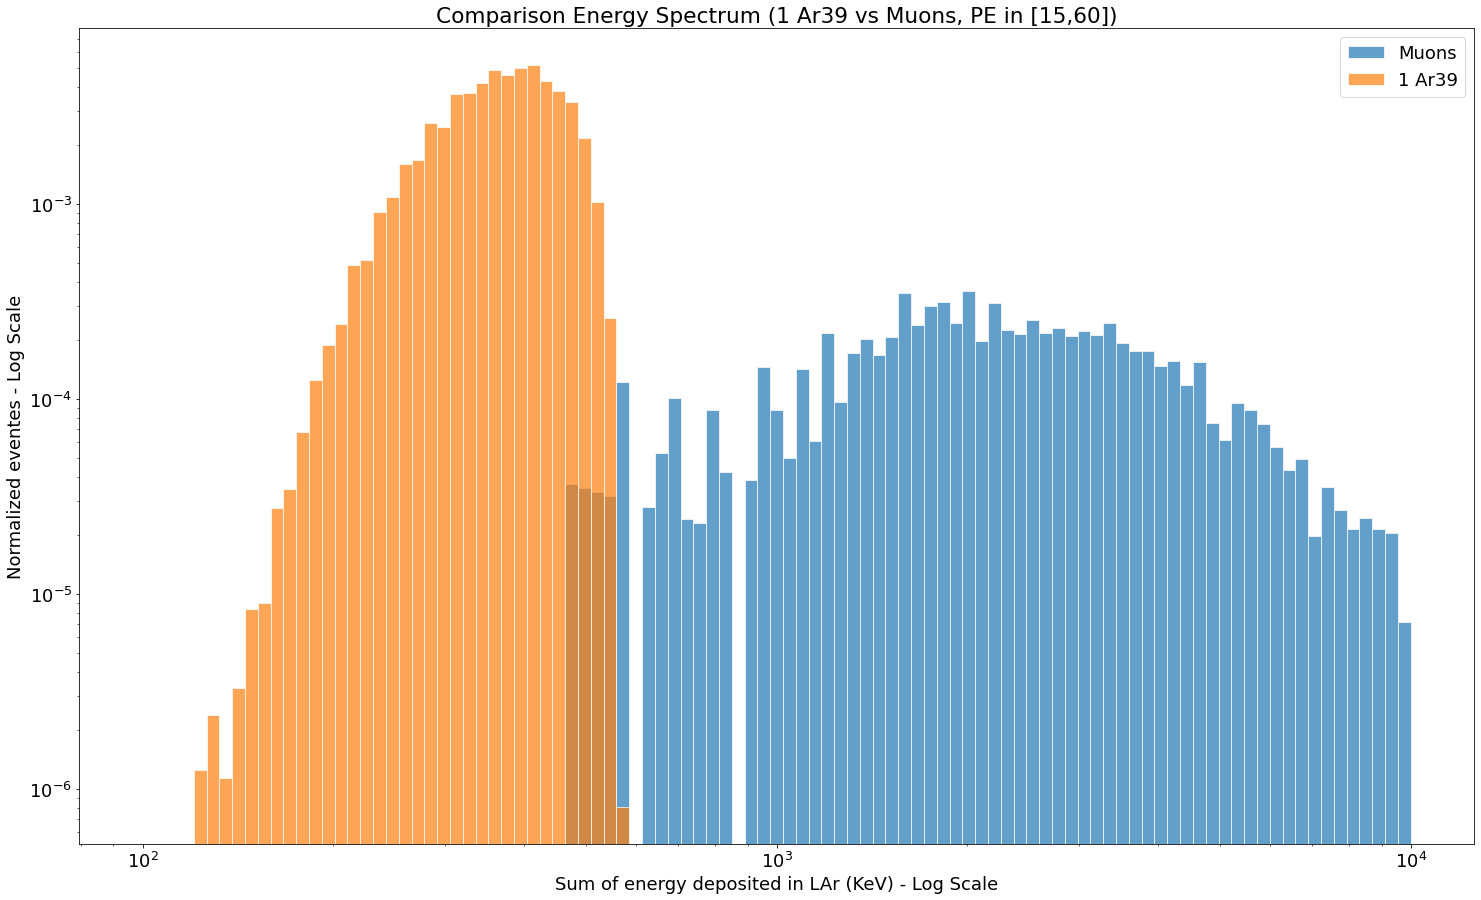

In [16]:
bins = np.logspace(2, 4, 100)
plt.hist(lemuons_cut.energydeposition, bins=bins, density=True, label="Muons", edgecolor='w', alpha=0.7)
plt.hist(ar39_cut.energydeposition, bins=bins, density=True, label="1 Ar39", edgecolor='w', alpha=0.7)
plt.title("Comparison Energy Spectrum (1 Ar39 vs Muons, PE in [{},{}])".format(min_pe, max_pe))
plt.xlabel("Sum of energy deposited in LAr (KeV) - Log Scale")
plt.ylabel("Normalized eventes - Log Scale")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

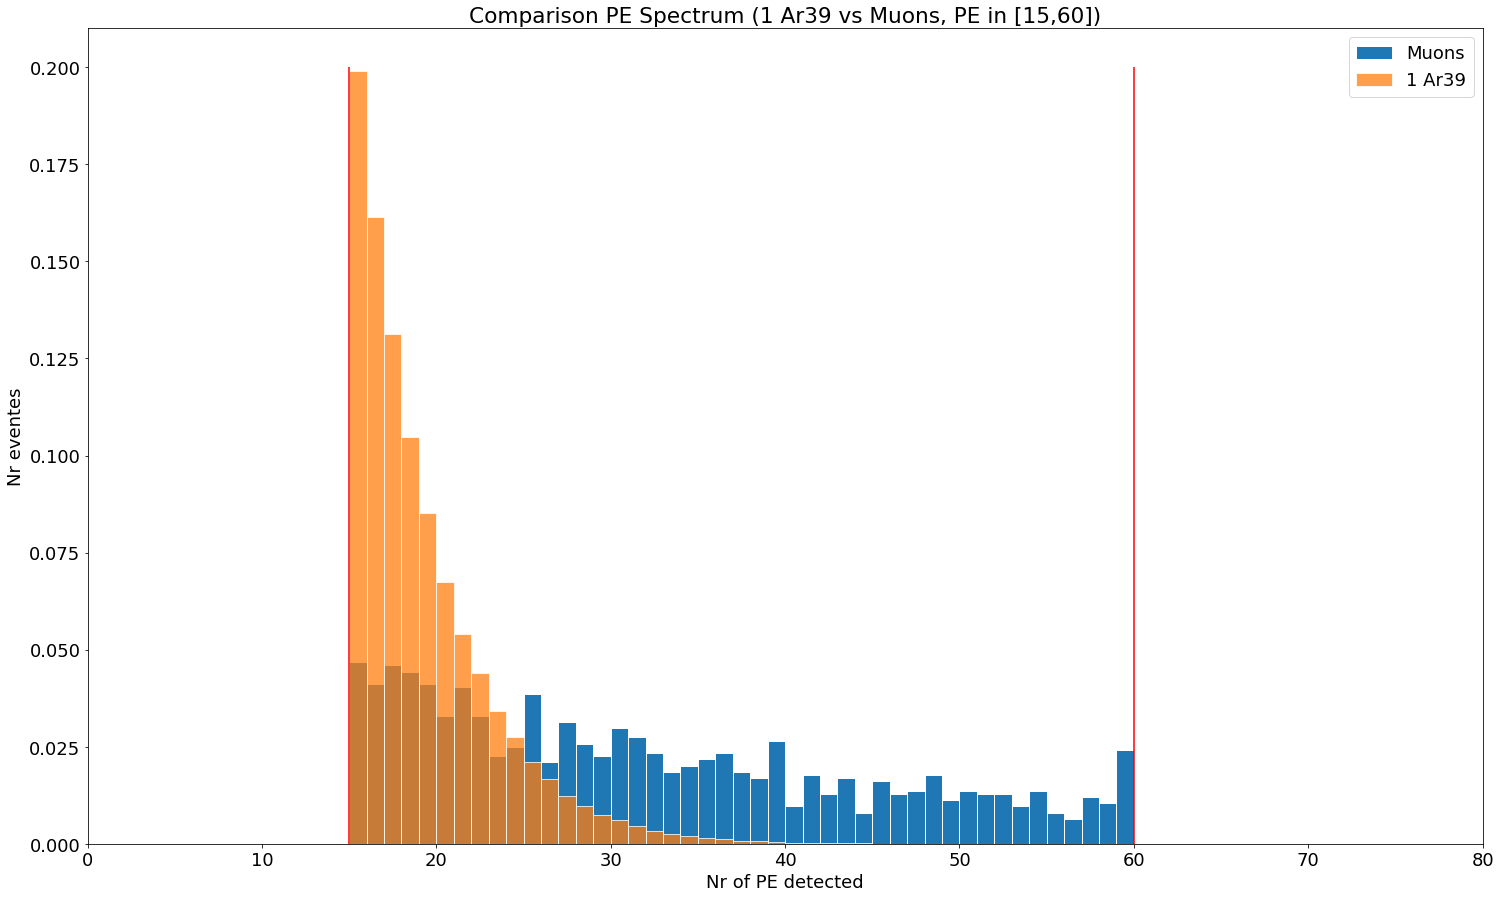

In [17]:
bins = np.linspace(0, 60, 61)
plt.hist(lemuons_cut.pedetected, bins=bins, density=True, label="Muons", edgecolor='w')
plt.hist(ar39_cut.pedetected, bins=bins, density=True, label="1 Ar39", edgecolor='w', alpha=0.75)
plt.title("Comparison PE Spectrum (1 Ar39 vs Muons, PE in [{},{}])".format(min_pe, max_pe))
plt.xlabel("Nr of PE detected")
plt.ylabel("Nr eventes")
plt.legend()
plt.xlim(0, 80)
plt.vlines(min_pe, ymin=0, ymax=0.2, label="Cut Min PE: {}".format(min_pe), color="r")
plt.vlines(max_pe, ymin=0, ymax=0.2, label="Cut Max PE: {}".format(max_pe), color="r")
plt.show()

# Remove Test data for later evaluation
Since we have `1241` muons and `138K` Ar39, we remove `241` muons (`~20%`) and `29000` Ar39 (`~20%`) for later evaluation.

In [18]:
n_train_mu, n_train_ar = 241, 29000
lemuons_cut_test, lemuons_cut_train = lemuons_cut.iloc[:n_train_mu, :], lemuons_cut.iloc[n_train_mu:, :]
ar39_cut_test, ar39_cut_train = ar39_cut.iloc[:n_train_ar, :], ar39_cut.iloc[n_train_ar:, :]
print("[Info] Muon Train {}, Test {}".format(len(lemuons_cut_train), len(lemuons_cut_test)))
print("[Info] Ar39 Train {}, Test {}".format(len(ar39_cut_train), len(ar39_cut_test)))

[Info] Muon Train 1000, Test 241
[Info] Ar39 Train 109701, Test 29000


# ML 1: simple dtrees on small amount of data

In [85]:
muon_data = augment_muons_by_roll(lemuons_cut_train, augmentation_factor=1)
print("[Info] The Augmented Muon dataset set has {} instances".format(len(muon_data)))

[Info] The Augmented Muon dataset set has 1000 instances


## Data selection (Undersampling Ar39)
Since we have a lot of Ar39 instances and the training data would be unbalanced, we undersample the Ar39 instances by selecting them at random.

However, we aim to maintain the critical instances with high PE detected that are just a few and don't won't to loose them with random sampling.
Then, we first compute the number of instances per each PE value, and normalize the distribution of Ar39 based on this.

[Info] The Scaled Ar39 dataset has 1082 instances


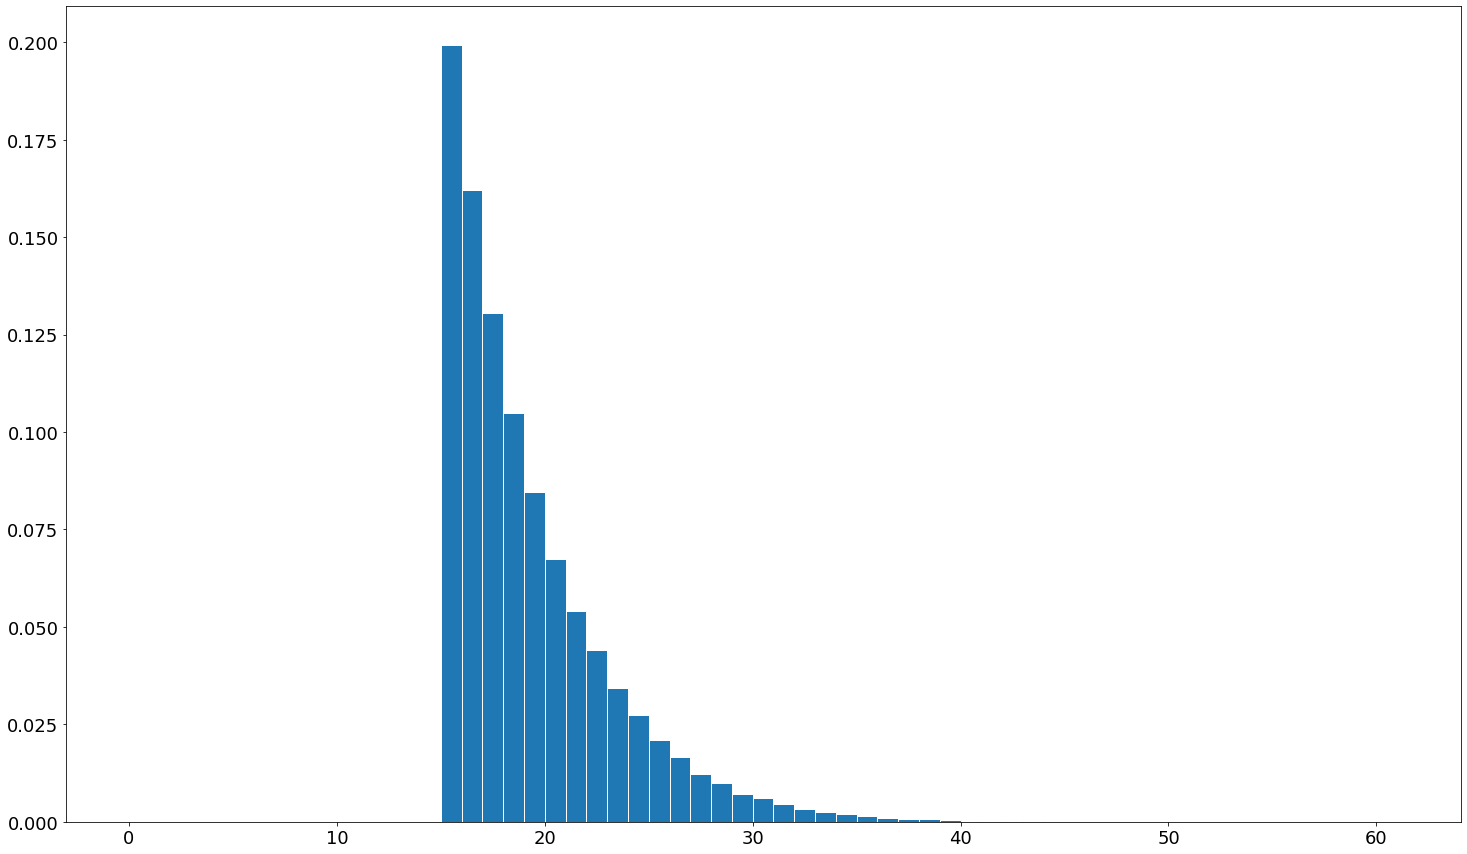

In [86]:
ar39_data = undersample_argon(ar39_cut_train, len(muon_data), augment_from_pe=35, augmentation_nr=5)
print("[Info] The Scaled Ar39 dataset has {} instances".format(len(ar39_data)))

## Prepare data with various quadrant-based features

In [28]:
nshiftings = [1, 2, 4, 8, 8]
widths = [72, 54, 36, 36, 18]
muons_datasets, ar39_1_datasets = produce_datasets_for_various_quandrant_features(muon_data, ar39_data, nshiftings, widths)

[Info] Computed quadrant features wt nshifting=1, width=72 for Muons
[Info] Computed quadrant features wt nshifting=1, width=72 for Ar39


/home/luigi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/luigi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[Info] Computed quadrant features wt nshifting=2, width=54 for Muons
[Info] Computed quadrant features wt nshifting=2, width=54 for Ar39
[Info] Computed quadrant features wt nshifting=4, width=36 for Muons
[Info] Computed quadrant features wt nshifting=4, width=36 for Ar39
[Info] Computed quadrant features wt nshifting=8, width=36 for Muons
[Info] Computed quadrant features wt nshifting=8, width=36 for Ar39
[Info] Computed quadrant features wt nshifting=8, width=18 for Muons
[Info] Computed quadrant features wt nshifting=8, width=18 for Ar39


## Train and Validation

[Info] Dataset with 3 features: nshifting=1, width=72
....................................................................................................
[Result] The Best DTree has depth: 4
[Result] Validation Set: Accuracy: 0.746, Precision: 0.768, Recall: 0.677, F1: 0.719

[Info] Dataset with 5 features: nshifting=2, width=54
....................................................................................................
[Result] The Best DTree has depth: 3
[Result] Validation Set: Accuracy: 0.752, Precision: 0.765, Recall: 0.698, F1: 0.730

[Info] Dataset with 9 features: nshifting=4, width=36
....................................................................................................
[Result] The Best DTree has depth: 5
[Result] Validation Set: Accuracy: 0.737, Precision: 0.762, Recall: 0.659, F1: 0.706

[Info] Dataset with 17 features: nshifting=8, width=36
....................................................................................................
[Result] T

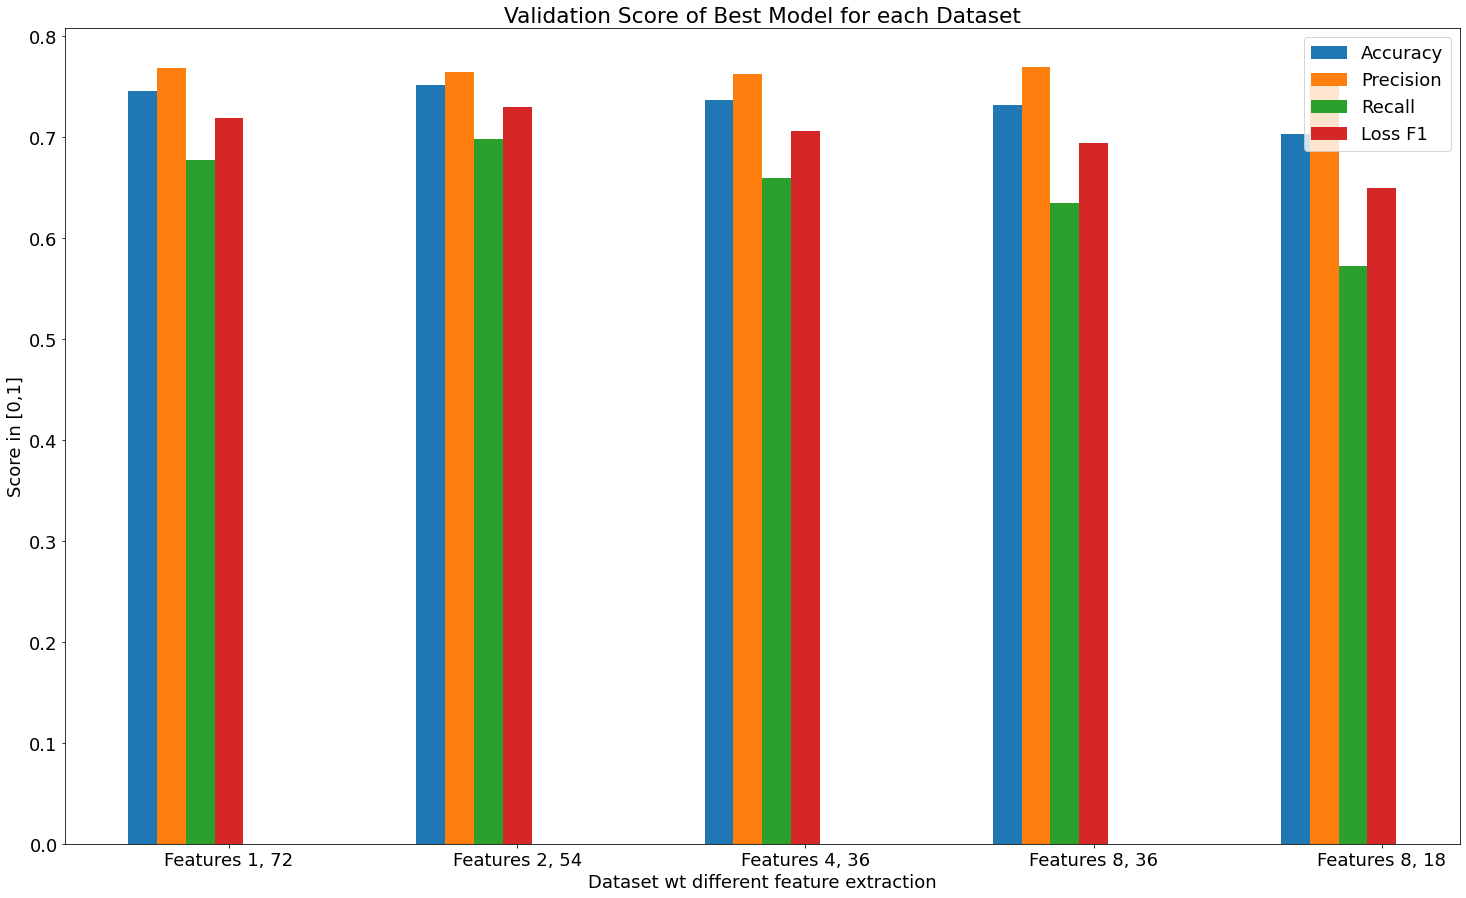

[Info] Dataset with 3 features: nshifting=1, width=72
....................................................................................................
[Result] The Best DTree has depth: 4
[Result] Validation Set: Accuracy: 0.741, Precision: 0.739, Recall: 0.715, F1: 0.726

[Info] Dataset with 5 features: nshifting=2, width=54
....................................................................................................
[Result] The Best DTree has depth: 3
[Result] Validation Set: Accuracy: 0.751, Precision: 0.759, Recall: 0.705, F1: 0.731

[Info] Dataset with 9 features: nshifting=4, width=36
....................................................................................................
[Result] The Best DTree has depth: 5
[Result] Validation Set: Accuracy: 0.745, Precision: 0.769, Recall: 0.674, F1: 0.718

[Info] Dataset with 17 features: nshifting=8, width=36
....................................................................................................
[Result] T

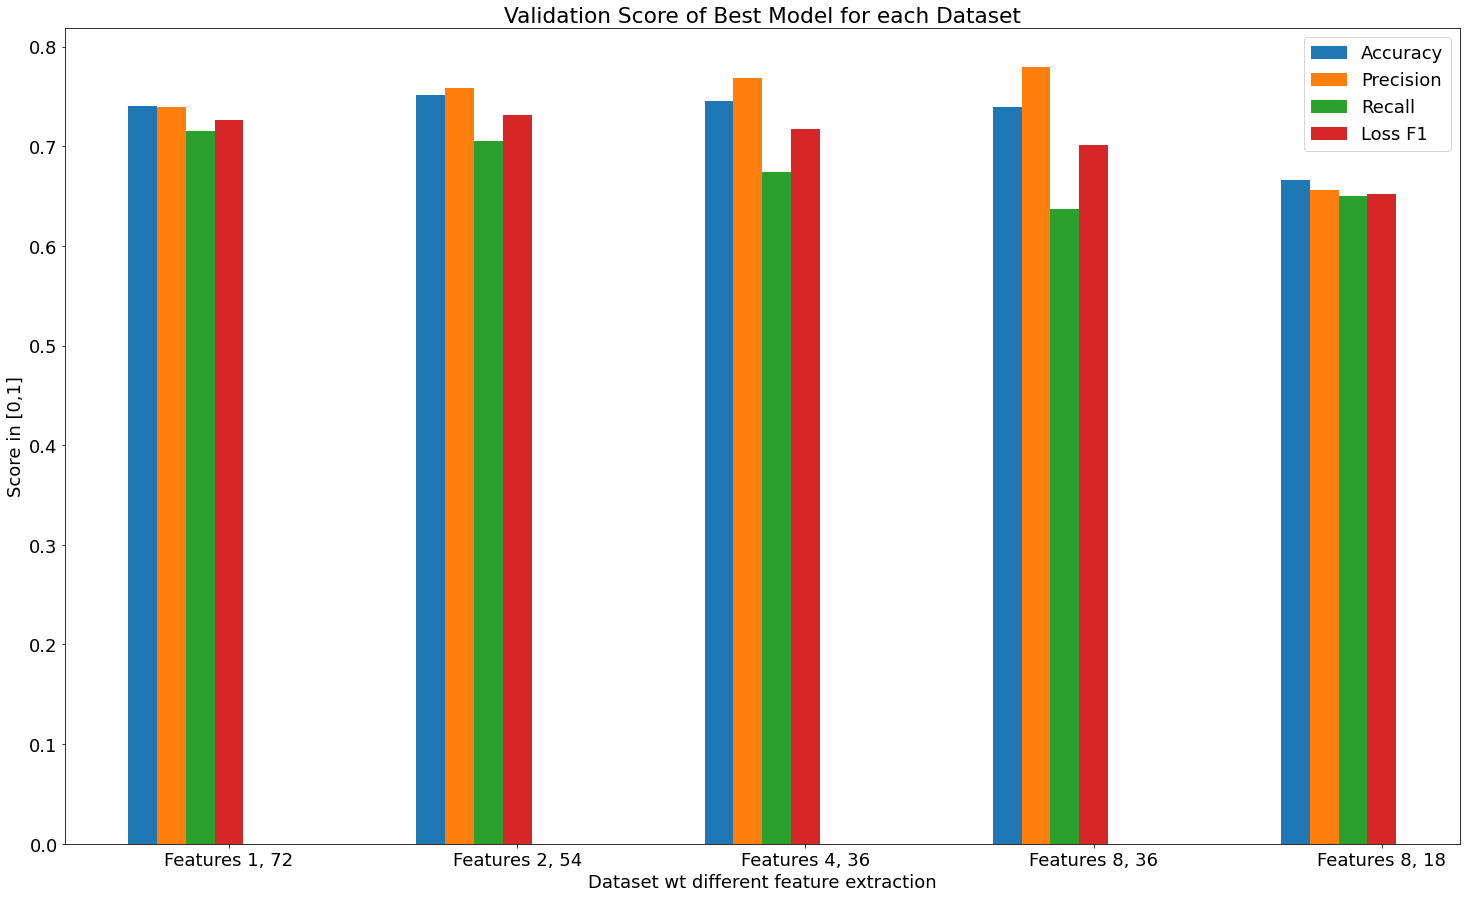

[Info] Dataset with 3 features: nshifting=1, width=72
....................................................................................................
[Result] The Best DTree has depth: 3
[Result] Validation Set: Accuracy: 0.742, Precision: 0.763, Recall: 0.673, F1: 0.714

[Info] Dataset with 5 features: nshifting=2, width=54
....................................................................................................
[Result] The Best DTree has depth: 3
[Result] Validation Set: Accuracy: 0.745, Precision: 0.764, Recall: 0.678, F1: 0.718

[Info] Dataset with 9 features: nshifting=4, width=36
....................................................................................................
[Result] The Best DTree has depth: 7
[Result] Validation Set: Accuracy: 0.746, Precision: 0.790, Recall: 0.641, F1: 0.708

[Info] Dataset with 17 features: nshifting=8, width=36
....................................................................................................
[Result] T

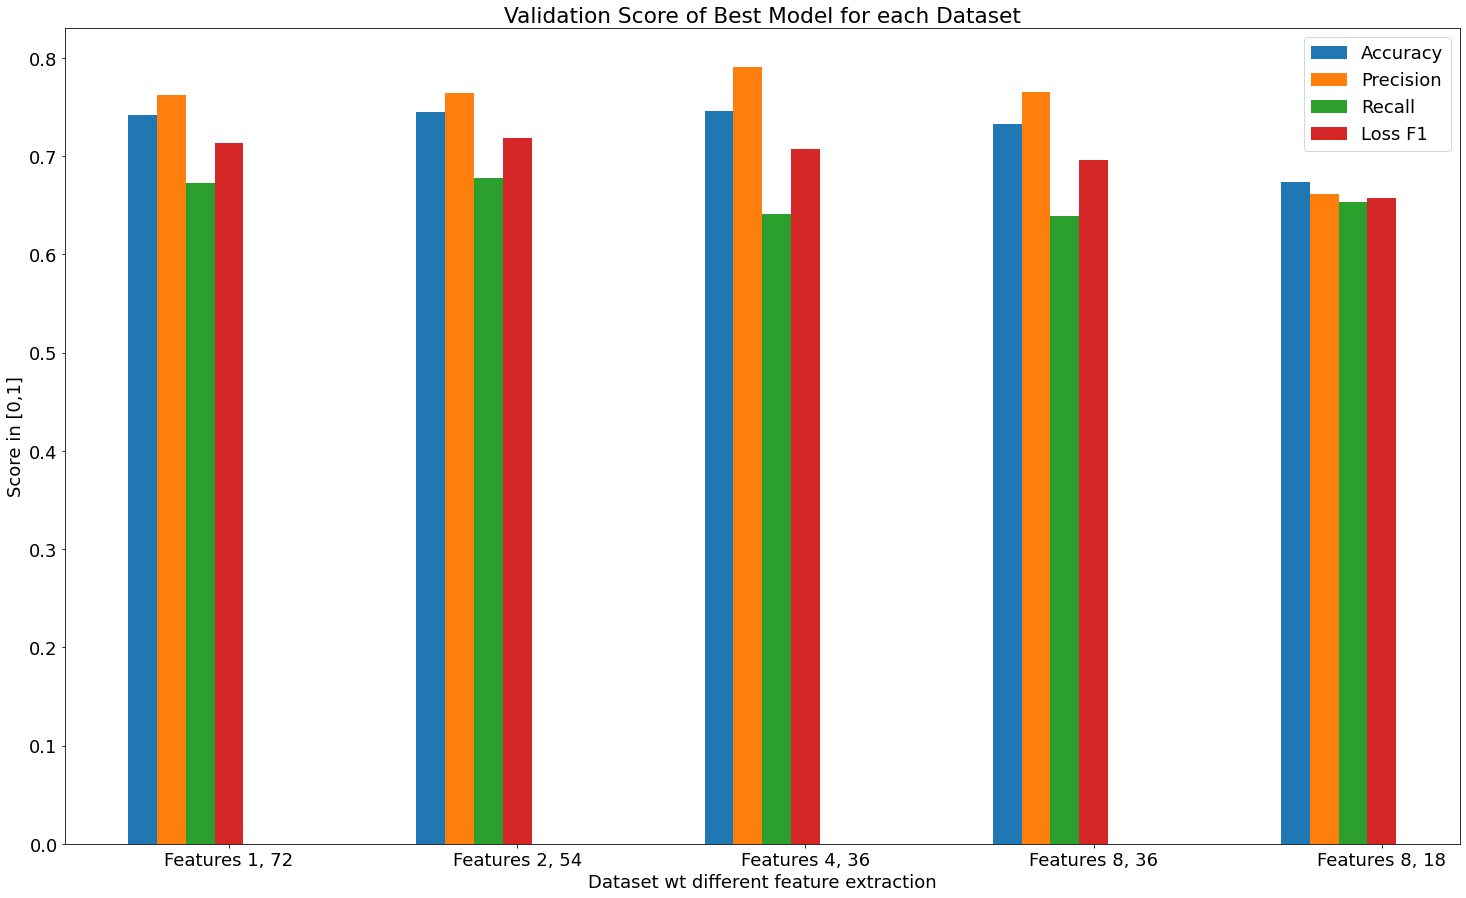

[Info] Dataset with 3 features: nshifting=1, width=72
....................................................................................................
[Result] The Best DTree has depth: 4
[Result] Validation Set: Accuracy: 0.735, Precision: 0.744, Recall: 0.696, F1: 0.717

[Info] Dataset with 5 features: nshifting=2, width=54
....................................................................................................
[Result] The Best DTree has depth: 4
[Result] Validation Set: Accuracy: 0.744, Precision: 0.744, Recall: 0.712, F1: 0.728

[Info] Dataset with 9 features: nshifting=4, width=36
....................................................................................................
[Result] The Best DTree has depth: 5
[Result] Validation Set: Accuracy: 0.743, Precision: 0.762, Recall: 0.673, F1: 0.715

[Info] Dataset with 17 features: nshifting=8, width=36
....................................................................................................
[Result] T

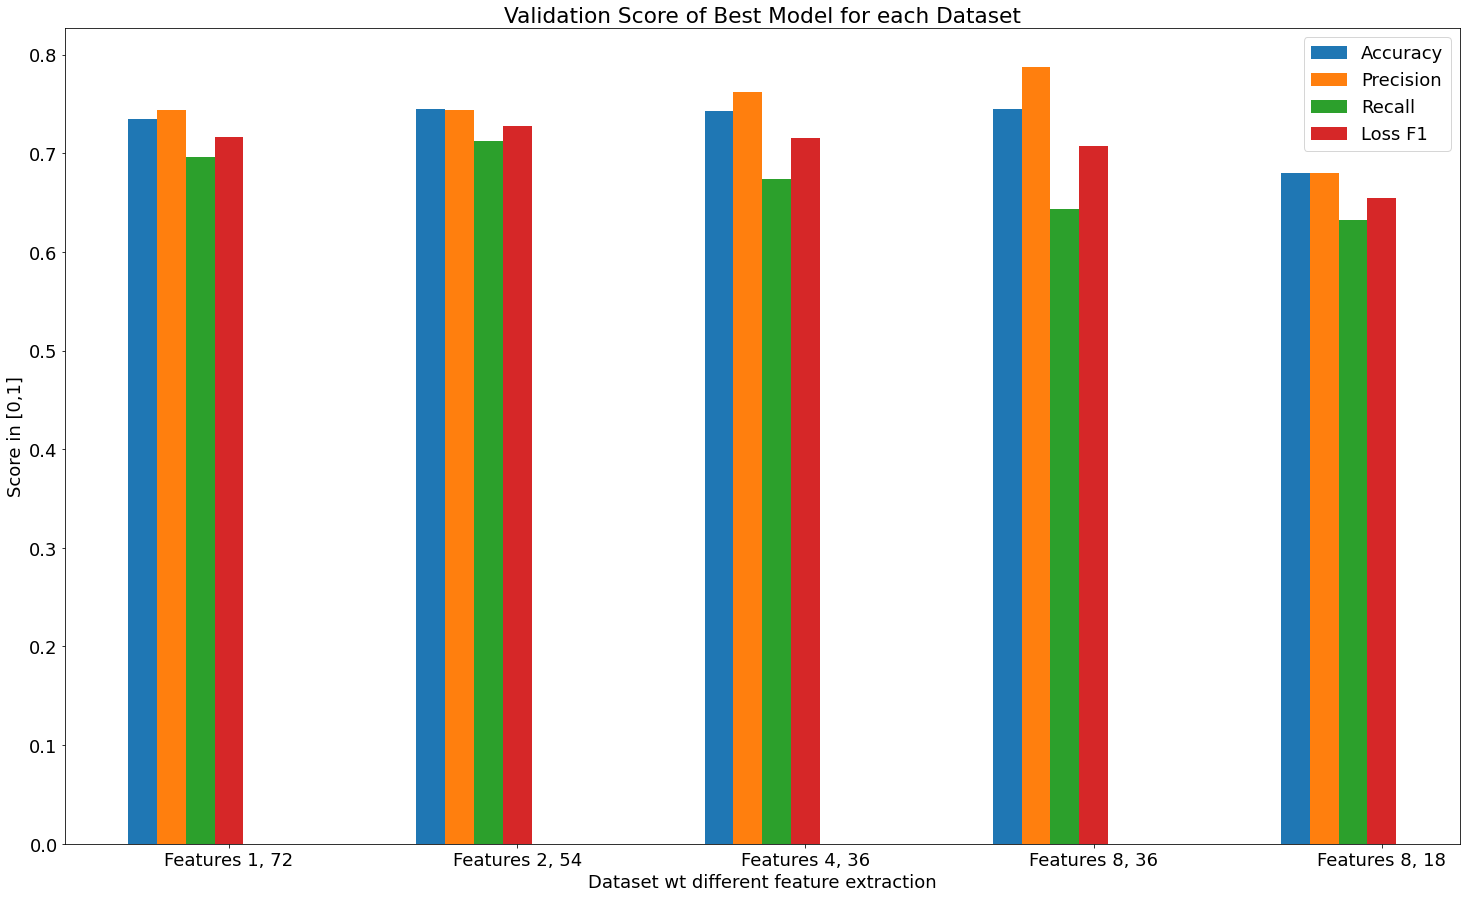

[Info] Dataset with 3 features: nshifting=1, width=72
....................................................................................................
[Result] The Best DTree has depth: 4
[Result] Validation Set: Accuracy: 0.743, Precision: 0.752, Recall: 0.698, F1: 0.721

[Info] Dataset with 5 features: nshifting=2, width=54
....................................................................................................
[Result] The Best DTree has depth: 3
[Result] Validation Set: Accuracy: 0.745, Precision: 0.755, Recall: 0.698, F1: 0.725

[Info] Dataset with 9 features: nshifting=4, width=36
....................................................................................................
[Result] The Best DTree has depth: 5
[Result] Validation Set: Accuracy: 0.739, Precision: 0.757, Recall: 0.674, F1: 0.713

[Info] Dataset with 17 features: nshifting=8, width=36
....................................................................................................
[Result] T

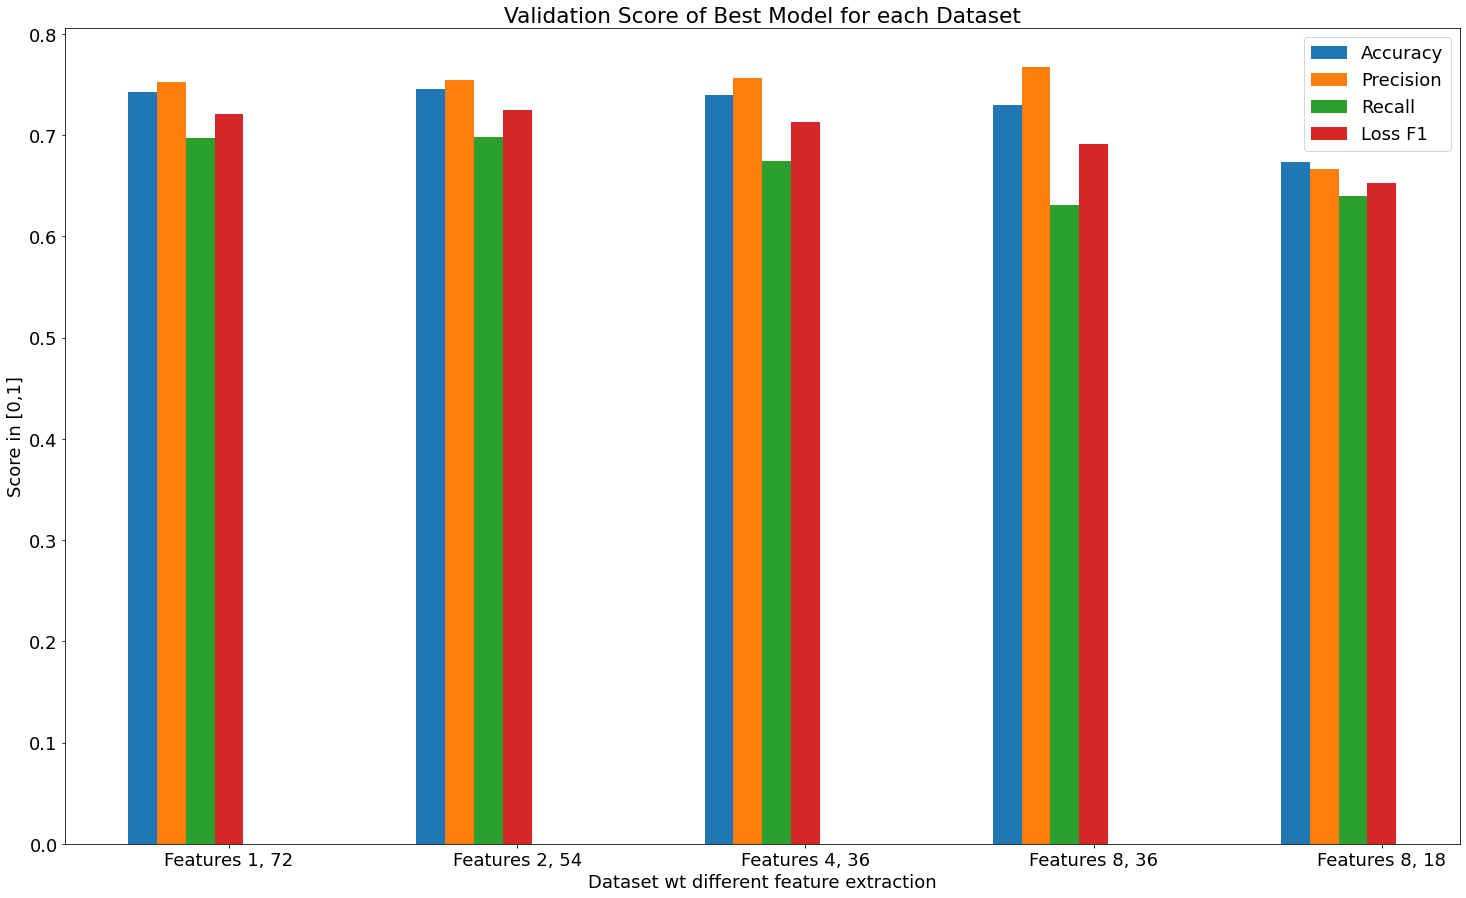

In [48]:
for seed in [0, 1, 2, 3, 4]:
    best_models, val_score_best_models = run_multifeatures_xvalidation(muons_datasets, ar39_1_datasets, max_depth_lim=100, plot_flag=False, rndseed=seed)
    plot_metrics_of_models(val_score_best_models)

From the series of train/validation above, we highlight the 3 most prosiming features:
1. nshiftings=1, width=72 that means that simple 2 features are adopted: mean pe, std dev.
1. nshiftings=2, width=54 that means that 4 features are adopted: mean pe, std dev for quadrant `[0,54), [36,18)`.
1. nshiftings=4, width=36 that means that 8 features are adopted: mean pe, std dev for quadrant `[0,36), [18,54), [36,72), [54,18)`.

We now test the best model for each of this dataset on the test data we isolated at the beginning.

## Test models

In [61]:
# prepare test data
skip_first_cols, nslices = 2, 72
muon_test_data = pd.DataFrame(lemuons_cut_test.iloc[:, skip_first_cols:skip_first_cols+nslices].to_numpy())
ar39_test_data = pd.DataFrame(ar39_cut_test.iloc[:, skip_first_cols:skip_first_cols+nslices].to_numpy())
# prepare features
prom_nshiftings = [1, 2, 4]
prom_widths = [72, 54, 36]
muons_datasets, ar39_1_datasets = produce_datasets_for_various_quandrant_features(muon_test_data, ar39_test_data, prom_nshiftings, prom_widths)

[Info] Computed quadrant features wt nshifting=1, width=72 for Muons
[Info] Computed quadrant features wt nshifting=1, width=72 for Ar39


/home/luigi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/luigi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[Info] Computed quadrant features wt nshifting=2, width=54 for Muons
[Info] Computed quadrant features wt nshifting=2, width=54 for Ar39
[Info] Computed quadrant features wt nshifting=4, width=36 for Muons
[Info] Computed quadrant features wt nshifting=4, width=36 for Ar39


In [80]:
for model, muon_features, ar39_1_features in zip(best_models[:3], muons_datasets, ar39_1_datasets):
    test_model(muon_features, ar39_1_features, model)

[Info] Dataset with 3 features
[Info] DTree, Max Depth: 4
[Result] Conf. Matrix: TN: 27084, FP: 1916, FN: 98, TP: 143 | TPR: 59.34%, FPR: 6.61%

[Info] Dataset with 5 features
[Info] DTree, Max Depth: 3
[Result] Conf. Matrix: TN: 24196, FP: 4804, FN: 76, TP: 165 | TPR: 68.46%, FPR: 16.57%

[Info] Dataset with 9 features
[Info] DTree, Max Depth: 5
[Result] Conf. Matrix: TN: 24013, FP: 4987, FN: 70, TP: 171 | TPR: 70.95%, FPR: 17.20%



### Considerations
#### Rejection Ar39
Given `6M` Ar39 aquisitions (*NPE>0*) that represent 98.83% of the background, we perform the following strategy:
1. Reject all the aquisitions with <15 PE. (from `6M` to `138701` Ar39)
1. The aquisitions with >=15PE are given to the DTree with 2 features (*mean PE, std dev*).
Considering its `FPR=6.61%`, it misclassify `138701*.0661=9169` aquisitions.

The resulting trigger rate is `(9169/6M * 0.9883 + 0.0117) * 2353 = 31 Hz`.

#### Efficiency
Given `14836` Muons aquisitions (*NPE>0*), we perform the following strategy:
1. Accept all the aquisitions with >60 PE. (accept `10205` instances)
1. Reject all the aquisitions with <15 PE. (loose `3390` instances)
1. The remaining `1241` aquisitions with 15<=PE<=60 are given to the DTree with 2 features (*mean PE, std dev*).
Considering its `TPR=59.34%`, it classify `736` muons and misclassify `505` muons.

The resulting efficiency is `(10205 + 736) / 14836 = 73.75 %`.

# ML2: Introduce Data Augmentation
## Data augmentation (Oversampling Muons)
Idea: the cylinder is symmetric, we can "roll" (shift over columns) the data leveraging this simmetry. For each event, we perform 10 shiftings over the columns.

Pros:
1. the model learns that the classification is not dependent on the position.
1. the available data are 10x more.

Cons:
1. this augmentation could lead to overfitting the training data. we will see on test.

[Info] The Augmented Muon dataset set has 2000 instances
[Info] The Scaled Ar39 dataset has 2211 instances


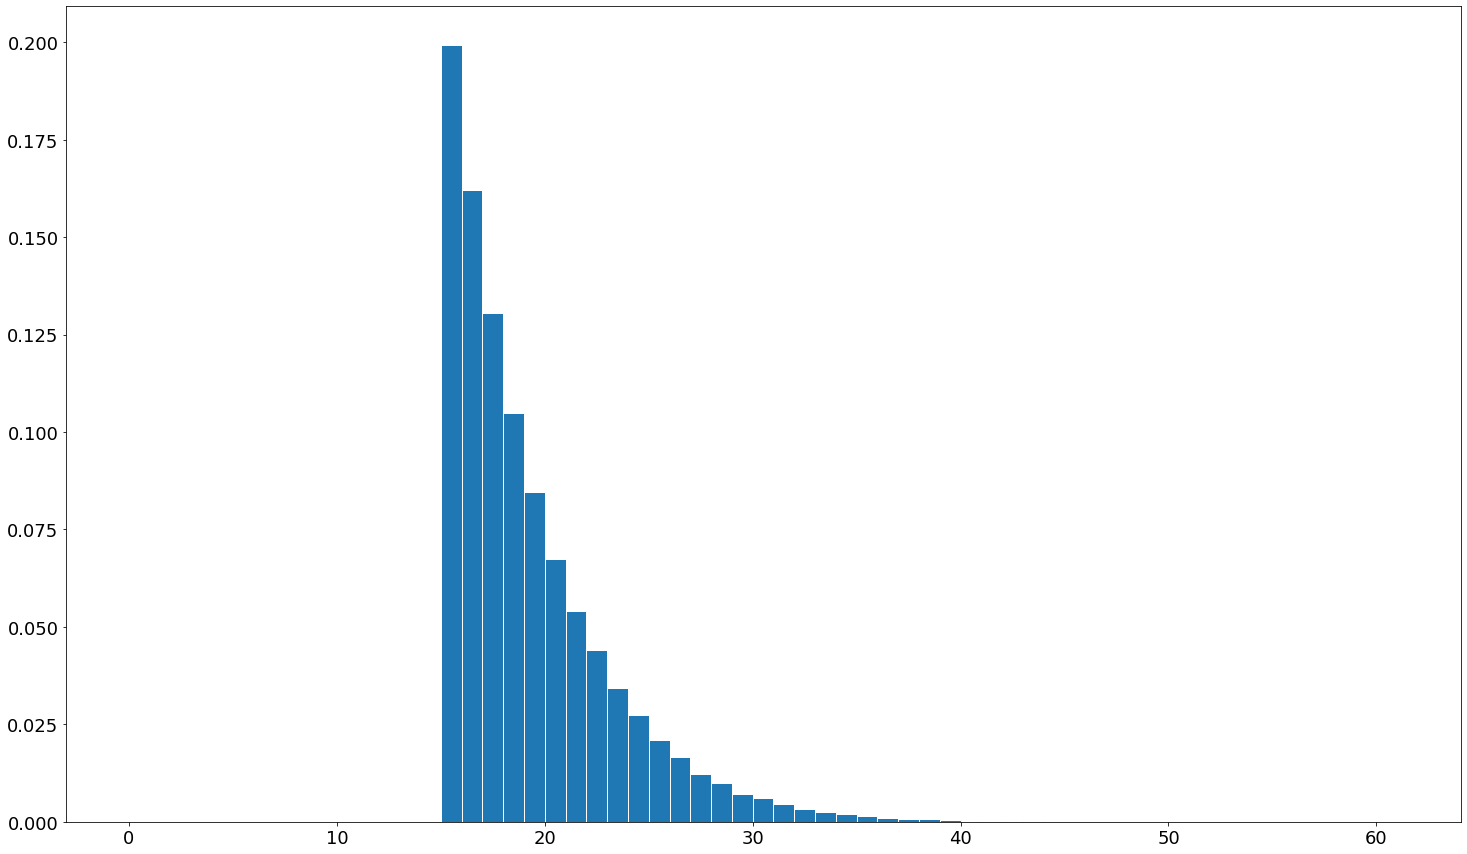

In [129]:
muon_data = augment_muons_by_roll(lemuons_cut_train, augmentation_factor=2)
print("[Info] The Augmented Muon dataset set has {} instances".format(len(muon_data)))
ar39_data = undersample_argon(ar39_cut_train, len(muon_data), augment_from_pe=30, augmentation_nr=15)
print("[Info] The Scaled Ar39 dataset has {} instances".format(len(ar39_data)))

In [130]:
nshiftings = [1, 2, 4, 8, 8]
widths = [72, 54, 36, 36, 18]
muons_datasets, ar39_1_datasets = produce_datasets_for_various_quandrant_features(muon_data, ar39_data, nshiftings, widths)

[Info] Computed quadrant features wt nshifting=1, width=72 for Muons
[Info] Computed quadrant features wt nshifting=1, width=72 for Ar39


/home/luigi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/luigi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[Info] Computed quadrant features wt nshifting=2, width=54 for Muons
[Info] Computed quadrant features wt nshifting=2, width=54 for Ar39
[Info] Computed quadrant features wt nshifting=4, width=36 for Muons
[Info] Computed quadrant features wt nshifting=4, width=36 for Ar39
[Info] Computed quadrant features wt nshifting=8, width=36 for Muons
[Info] Computed quadrant features wt nshifting=8, width=36 for Ar39
[Info] Computed quadrant features wt nshifting=8, width=18 for Muons
[Info] Computed quadrant features wt nshifting=8, width=18 for Ar39


[Info] Dataset with 3 features: nshifting=1, width=72
....................
[Result] The Best DTree has depth: 6
[Result] Validation Set: Accuracy: 0.739, Precision: 0.732, Recall: 0.712, F1: 0.722

[Info] Dataset with 5 features: nshifting=2, width=54
....................
[Result] The Best DTree has depth: 4
[Result] Validation Set: Accuracy: 0.746, Precision: 0.731, Recall: 0.738, F1: 0.734

[Info] Dataset with 9 features: nshifting=4, width=36
....................
[Result] The Best DTree has depth: 8
[Result] Validation Set: Accuracy: 0.737, Precision: 0.767, Recall: 0.642, F1: 0.698

[Info] Dataset with 17 features: nshifting=8, width=36
....................
[Result] The Best DTree has depth: 7
[Result] Validation Set: Accuracy: 0.739, Precision: 0.757, Recall: 0.664, F1: 0.707

[Info] Dataset with 17 features: nshifting=8, width=18
....................
[Result] The Best DTree has depth: 18
[Result] Validation Set: Accuracy: 0.697, Precision: 0.725, Recall: 0.582, F1: 0.646



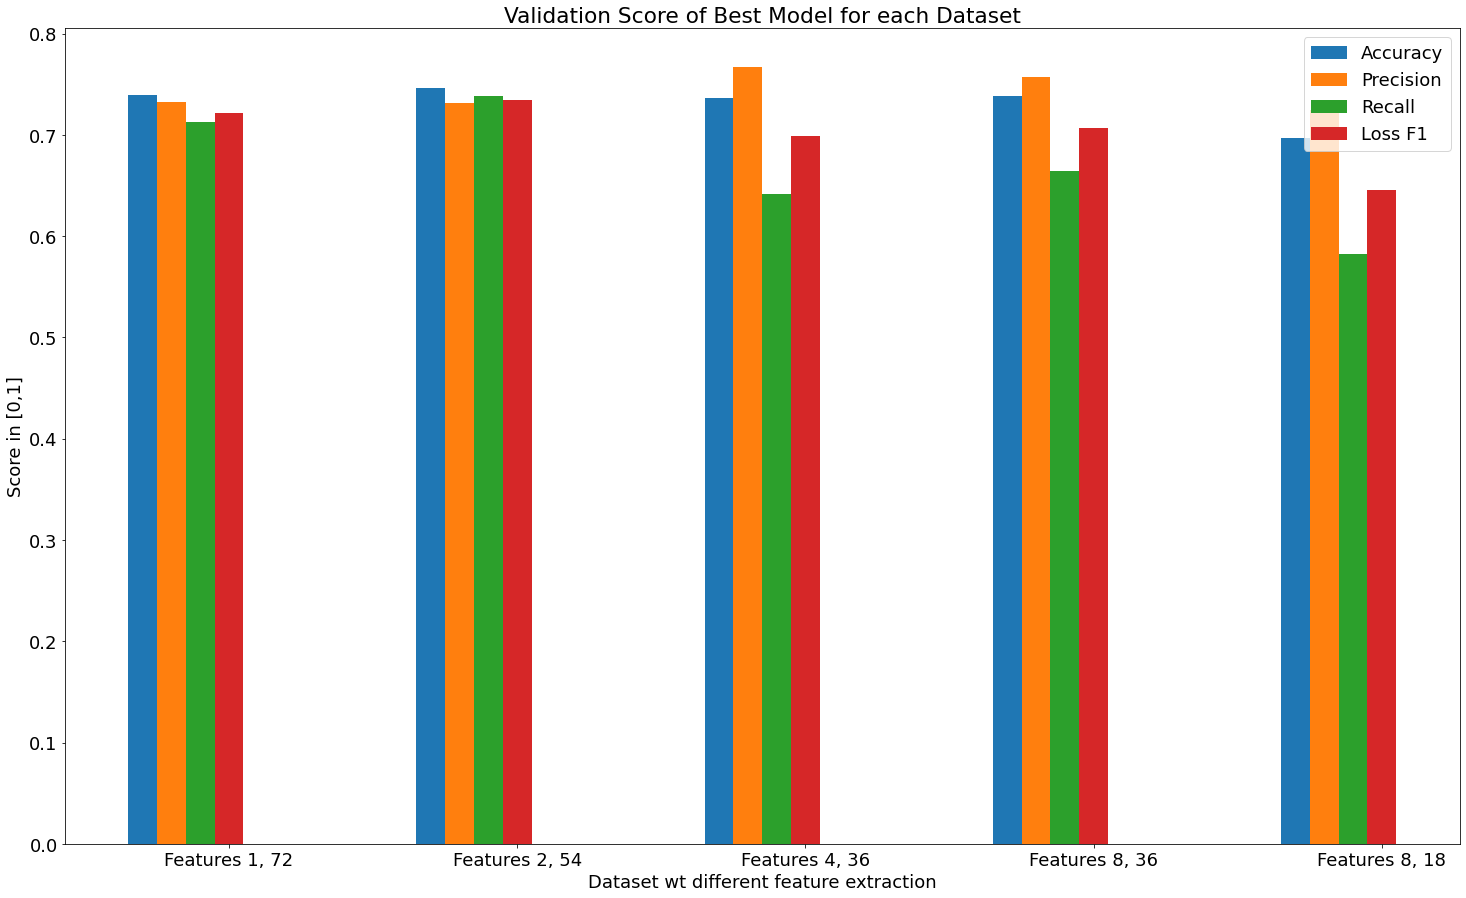

[Info] Dataset with 3 features: nshifting=1, width=72
....................
[Result] The Best DTree has depth: 6
[Result] Validation Set: Accuracy: 0.744, Precision: 0.736, Recall: 0.720, F1: 0.727

[Info] Dataset with 5 features: nshifting=2, width=54
....................
[Result] The Best DTree has depth: 4
[Result] Validation Set: Accuracy: 0.746, Precision: 0.730, Recall: 0.739, F1: 0.733

[Info] Dataset with 9 features: nshifting=4, width=36
....................
[Result] The Best DTree has depth: 6
[Result] Validation Set: Accuracy: 0.743, Precision: 0.764, Recall: 0.663, F1: 0.709

[Info] Dataset with 17 features: nshifting=8, width=36
....................
[Result] The Best DTree has depth: 6
[Result] Validation Set: Accuracy: 0.737, Precision: 0.757, Recall: 0.661, F1: 0.704

[Info] Dataset with 17 features: nshifting=8, width=18
....................
[Result] The Best DTree has depth: 20
[Result] Validation Set: Accuracy: 0.687, Precision: 0.701, Recall: 0.597, F1: 0.644



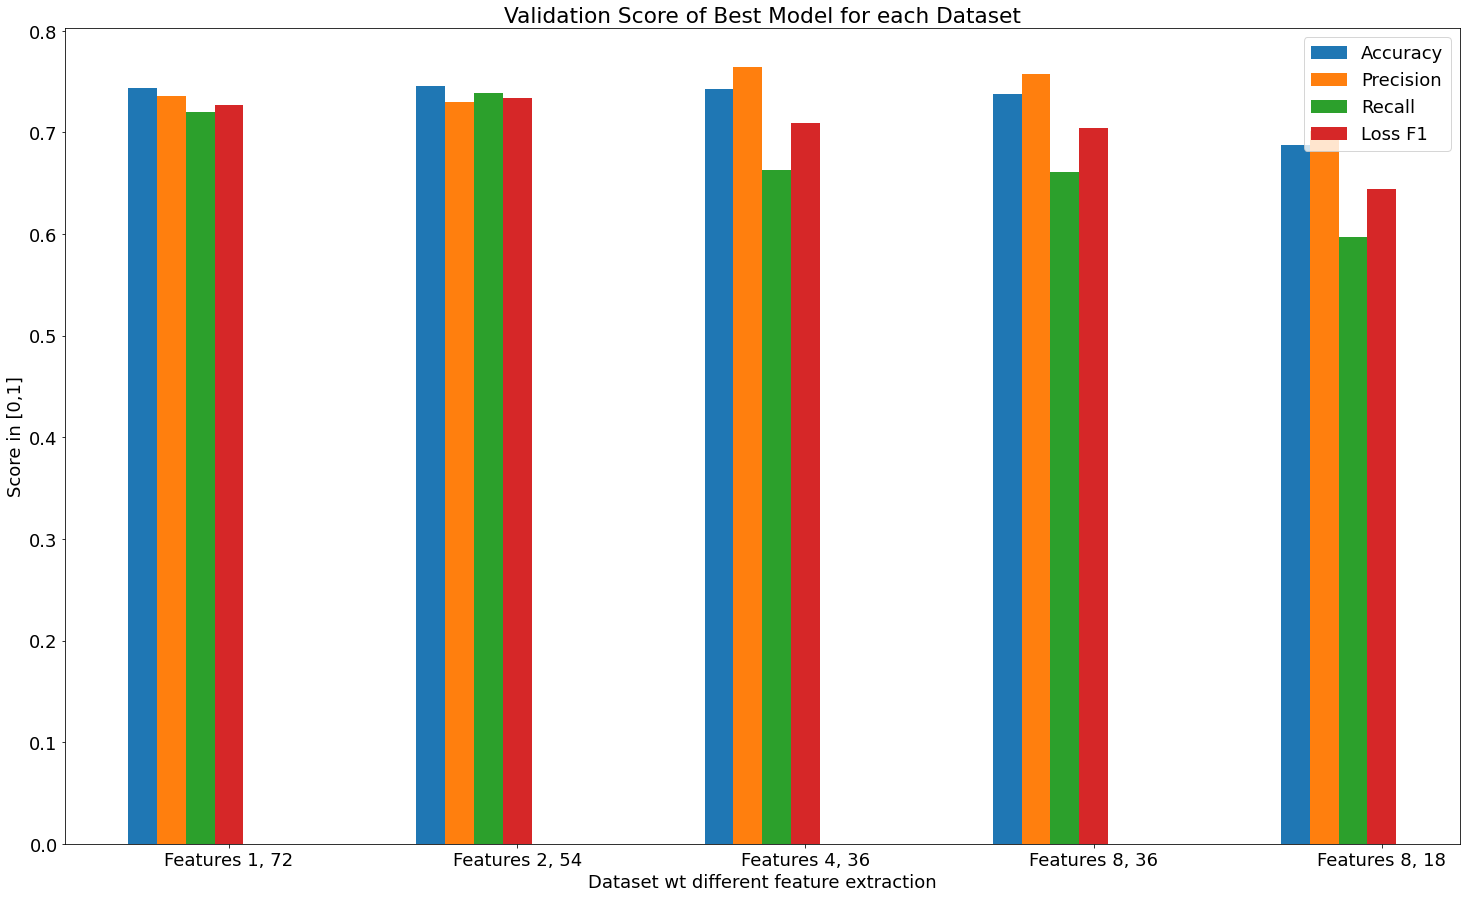

[Info] Dataset with 3 features: nshifting=1, width=72
....................
[Result] The Best DTree has depth: 4
[Result] Validation Set: Accuracy: 0.743, Precision: 0.739, Recall: 0.709, F1: 0.724

[Info] Dataset with 5 features: nshifting=2, width=54
....................
[Result] The Best DTree has depth: 4
[Result] Validation Set: Accuracy: 0.751, Precision: 0.738, Recall: 0.741, F1: 0.739

[Info] Dataset with 9 features: nshifting=4, width=36
....................
[Result] The Best DTree has depth: 6
[Result] Validation Set: Accuracy: 0.741, Precision: 0.762, Recall: 0.663, F1: 0.709

[Info] Dataset with 17 features: nshifting=8, width=36
....................
[Result] The Best DTree has depth: 6
[Result] Validation Set: Accuracy: 0.743, Precision: 0.758, Recall: 0.672, F1: 0.713

[Info] Dataset with 17 features: nshifting=8, width=18
....................
[Result] The Best DTree has depth: 20
[Result] Validation Set: Accuracy: 0.692, Precision: 0.701, Recall: 0.615, F1: 0.655



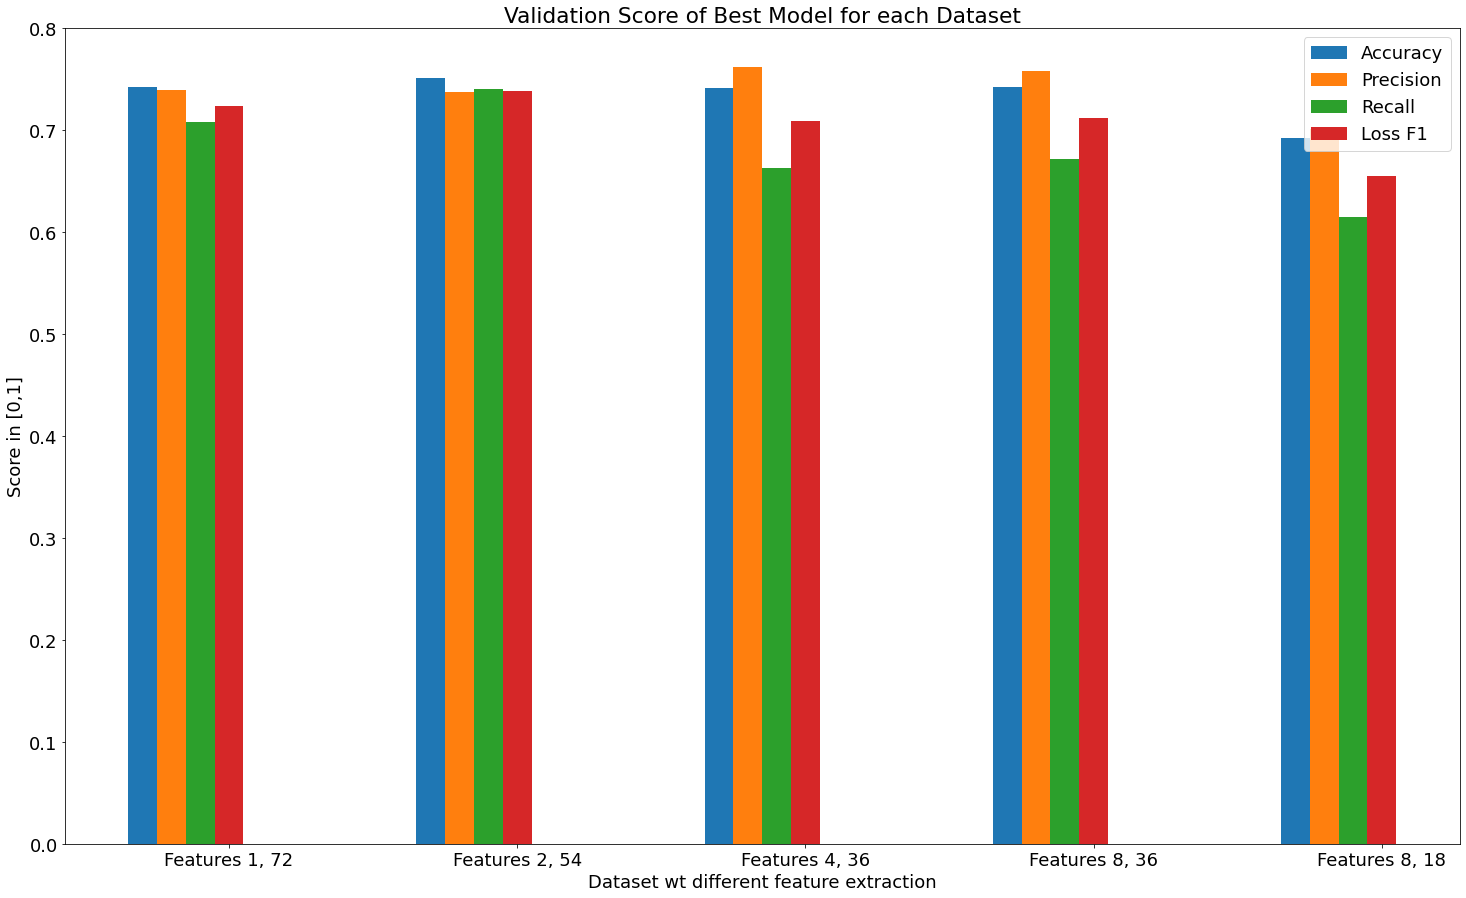

[Info] Dataset with 3 features: nshifting=1, width=72
....................
[Result] The Best DTree has depth: 6
[Result] Validation Set: Accuracy: 0.741, Precision: 0.734, Recall: 0.716, F1: 0.724

[Info] Dataset with 5 features: nshifting=2, width=54
....................
[Result] The Best DTree has depth: 4
[Result] Validation Set: Accuracy: 0.753, Precision: 0.734, Recall: 0.754, F1: 0.744

[Info] Dataset with 9 features: nshifting=4, width=36
....................
[Result] The Best DTree has depth: 7
[Result] Validation Set: Accuracy: 0.741, Precision: 0.759, Recall: 0.667, F1: 0.709

[Info] Dataset with 17 features: nshifting=8, width=36
....................
[Result] The Best DTree has depth: 7
[Result] Validation Set: Accuracy: 0.740, Precision: 0.749, Recall: 0.684, F1: 0.714

[Info] Dataset with 17 features: nshifting=8, width=18
....................
[Result] The Best DTree has depth: 16
[Result] Validation Set: Accuracy: 0.693, Precision: 0.715, Recall: 0.594, F1: 0.647



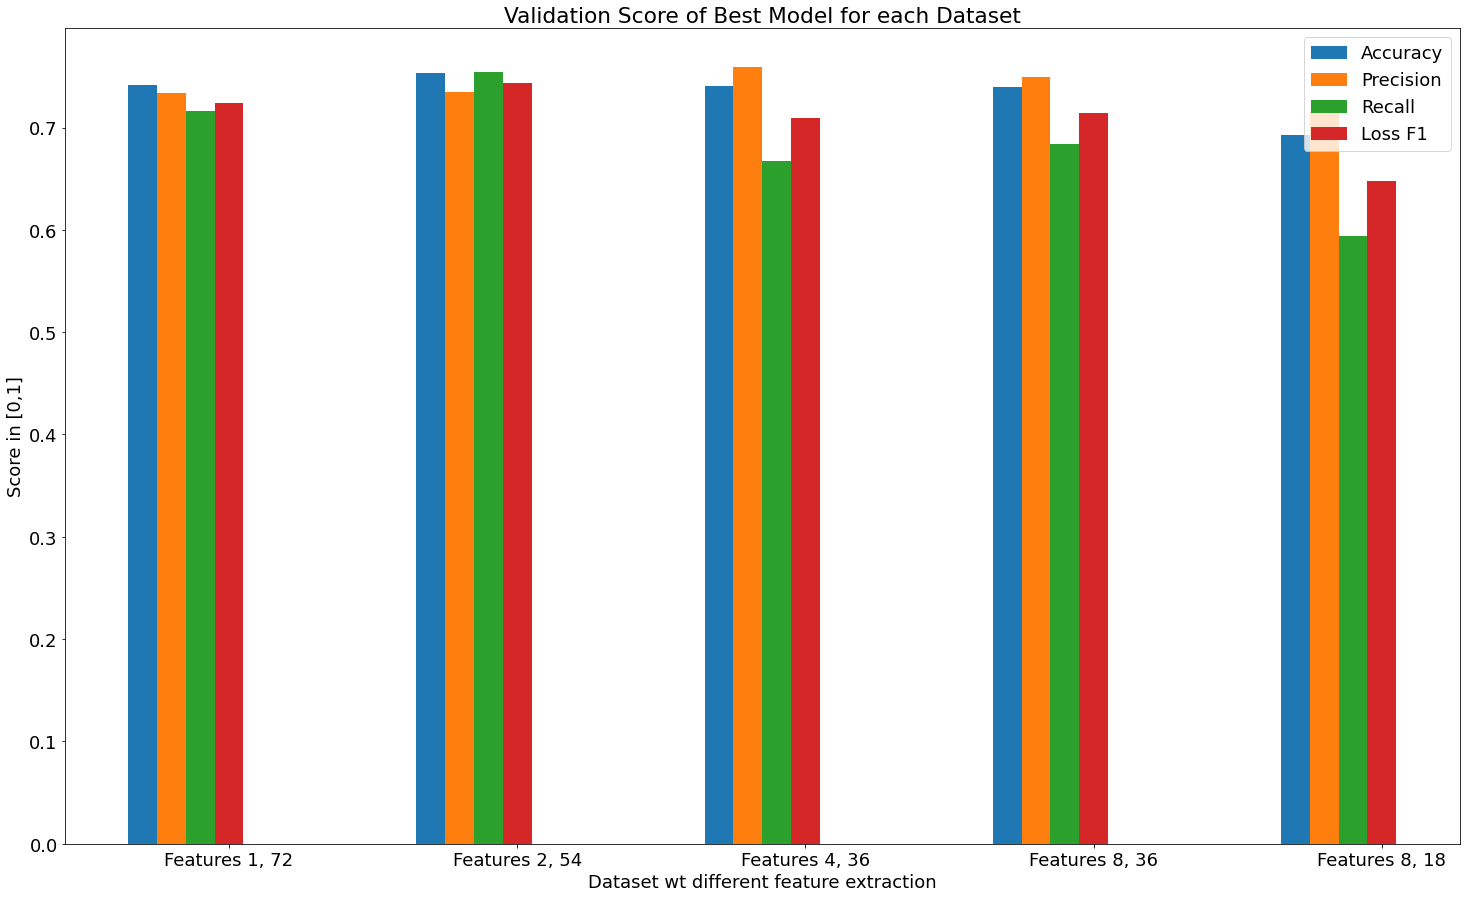

[Info] Dataset with 3 features: nshifting=1, width=72
....................
[Result] The Best DTree has depth: 19
[Result] Validation Set: Accuracy: 0.741, Precision: 0.723, Recall: 0.738, F1: 0.730

[Info] Dataset with 5 features: nshifting=2, width=54
....................
[Result] The Best DTree has depth: 4
[Result] Validation Set: Accuracy: 0.744, Precision: 0.738, Recall: 0.722, F1: 0.728

[Info] Dataset with 9 features: nshifting=4, width=36
....................
[Result] The Best DTree has depth: 8
[Result] Validation Set: Accuracy: 0.740, Precision: 0.761, Recall: 0.665, F1: 0.708

[Info] Dataset with 17 features: nshifting=8, width=36
....................
[Result] The Best DTree has depth: 6
[Result] Validation Set: Accuracy: 0.732, Precision: 0.756, Recall: 0.647, F1: 0.696

[Info] Dataset with 17 features: nshifting=8, width=18
....................
[Result] The Best DTree has depth: 19
[Result] Validation Set: Accuracy: 0.689, Precision: 0.708, Recall: 0.591, F1: 0.643



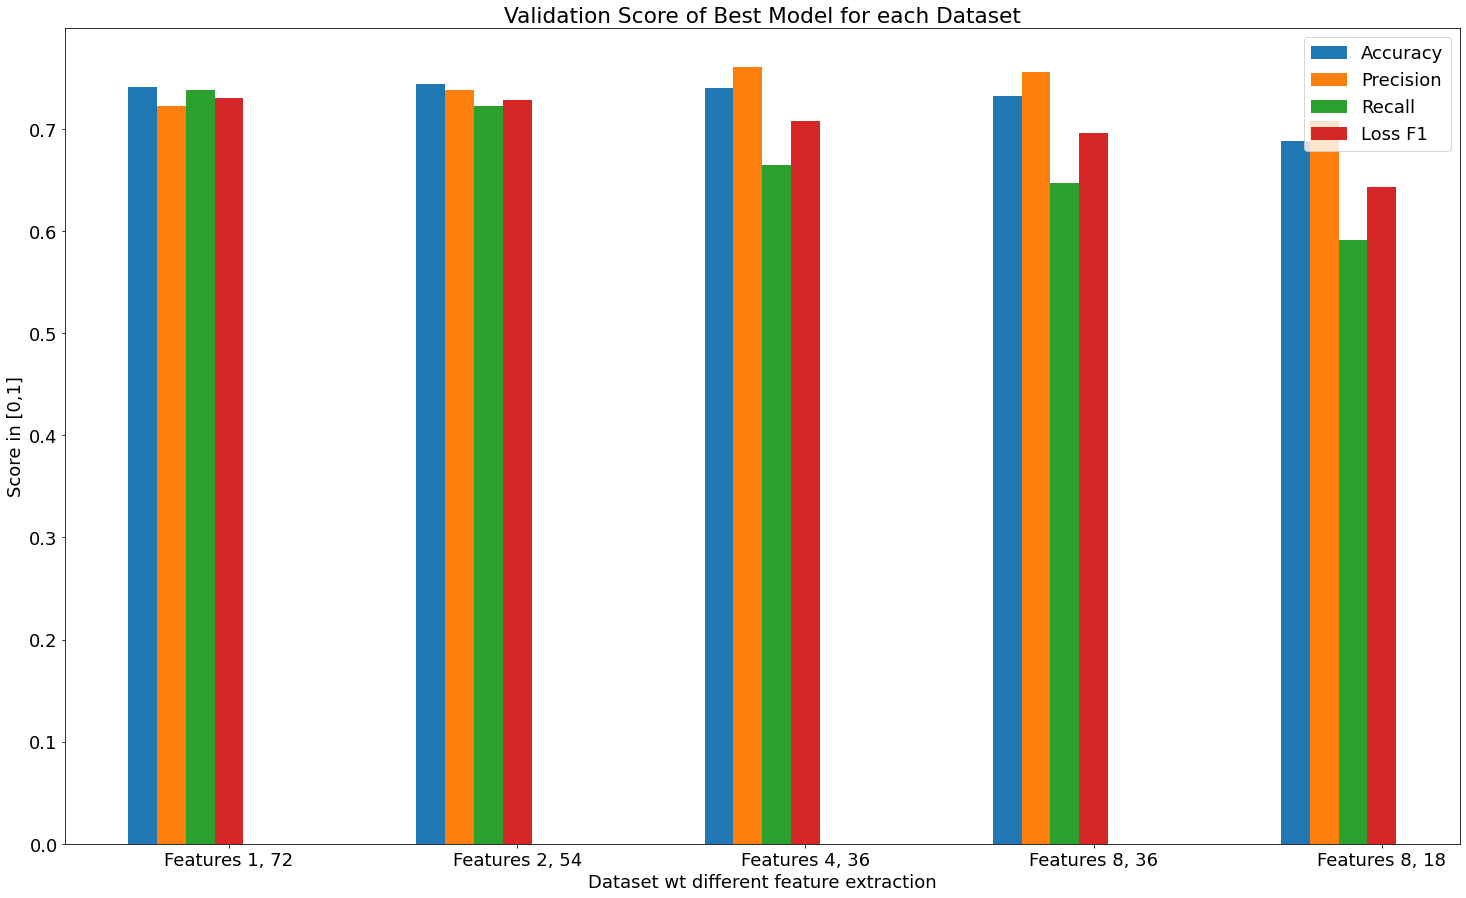

In [132]:
for seed in [0, 1, 2, 3, 4]:
    best_models, val_score_best_models = run_multifeatures_xvalidation(muons_datasets, ar39_1_datasets, max_depth_lim=20, plot_flag=False, rndseed=seed)
    plot_metrics_of_models(val_score_best_models)

## Test models

In [133]:
# prepare test data
skip_first_cols, nslices = 2, 72
muon_test_data = pd.DataFrame(lemuons_cut_test.iloc[:, skip_first_cols:skip_first_cols+nslices].to_numpy())
ar39_test_data = pd.DataFrame(ar39_cut_test.iloc[:, skip_first_cols:skip_first_cols+nslices].to_numpy())
# prepare features
prom_nshiftings = [1, 2, 4]
prom_widths = [72, 54, 36]
muons_datasets, ar39_1_datasets = produce_datasets_for_various_quandrant_features(muon_test_data, ar39_test_data, prom_nshiftings, prom_widths)

[Info] Computed quadrant features wt nshifting=1, width=72 for Muons
[Info] Computed quadrant features wt nshifting=1, width=72 for Ar39


/home/luigi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/luigi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[Info] Computed quadrant features wt nshifting=2, width=54 for Muons
[Info] Computed quadrant features wt nshifting=2, width=54 for Ar39
[Info] Computed quadrant features wt nshifting=4, width=36 for Muons
[Info] Computed quadrant features wt nshifting=4, width=36 for Ar39


In [134]:
for model, muon_features, ar39_1_features in zip(best_models[:3], muons_datasets, ar39_1_datasets):
    test_model(muon_features, ar39_1_features, model, "Dtree")

[Info] Dataset with 2 features
[Info] DTree, Max Depth: 19
[Result] Conf. Matrix: TN: 22824, FP: 6176, FN: 93, TP: 148 | TPR: 61.41%, FPR: 21.30%

[Info] Dataset with 4 features
[Info] DTree, Max Depth: 4
[Result] Conf. Matrix: TN: 24047, FP: 4953, FN: 61, TP: 180 | TPR: 74.69%, FPR: 17.08%

[Info] Dataset with 8 features
[Info] DTree, Max Depth: 8
[Result] Conf. Matrix: TN: 25315, FP: 3685, FN: 76, TP: 165 | TPR: 68.46%, FPR: 12.71%



### Considerations

#### Data augmentation on these features
I originally expected to see improvement on data augmentation. 
I thought it was a good idea to replicate the shifted instances to give the model the chance to learn something not dependent on where it occurs.

Unfortunately, I have not considered the kind of features that I am adopting and that the main requirement from this model is to minimize the `FPR`.

The data augmentation helps the model to improve in *efficiency*, in fact we can notice an improvement in TPR of the first two models. However, the increase of `FPR` is dominant for our porpuses.

The drawback of **overfitting** is significant, we can notice that event the simple models with 2,4,8 features present their best model with a big depth (`19, 8`) that clearly means that the model is overfitting the training data.

On this kind of features, data augmentation is dangerous! 
We should try it on other models that directly work on all the 71 aquisitions (e.g. NN) to see if improves...

# ML3: other models

[Info] The Augmented Muon dataset set has 1000 instances
[Info] The Scaled Ar39 dataset has 1082 instances


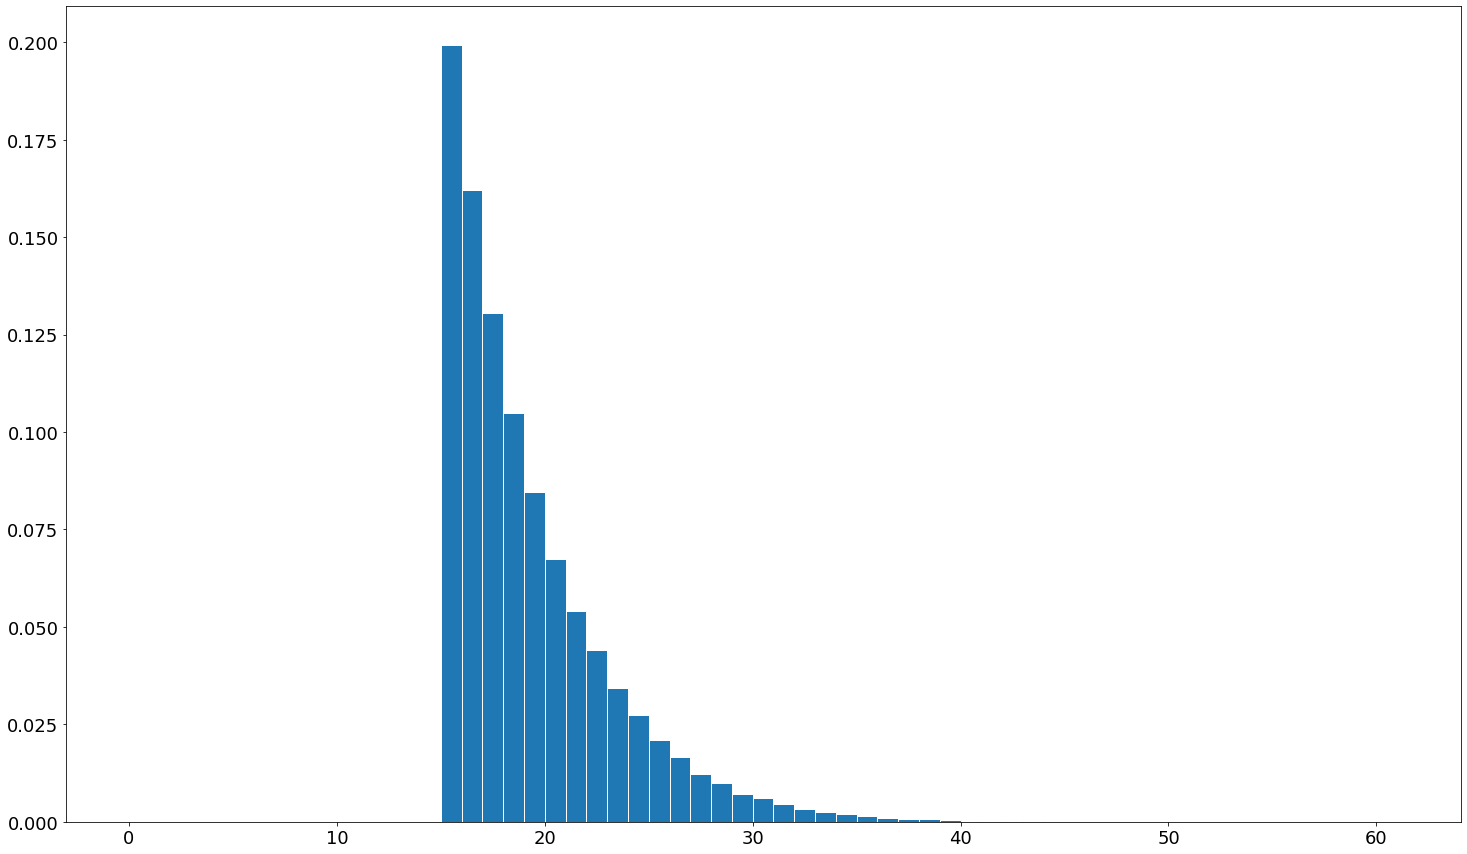

In [135]:
muon_data = augment_muons_by_roll(lemuons_cut_train, augmentation_factor=1)
print("[Info] The Augmented Muon dataset set has {} instances".format(len(muon_data)))
ar39_data = undersample_argon(ar39_cut_train, len(muon_data), augment_from_pe=35, augmentation_nr=5)
print("[Info] The Scaled Ar39 dataset has {} instances".format(len(ar39_data)))

In [136]:
nshiftings = [1, 2, 4, 8, 8]
widths = [72, 54, 36, 36, 18]
muons_datasets, ar39_1_datasets = produce_datasets_for_various_quandrant_features(muon_data, ar39_data, nshiftings, widths)

[Info] Computed quadrant features wt nshifting=1, width=72 for Muons
[Info] Computed quadrant features wt nshifting=1, width=72 for Ar39


/home/luigi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/luigi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[Info] Computed quadrant features wt nshifting=2, width=54 for Muons
[Info] Computed quadrant features wt nshifting=2, width=54 for Ar39
[Info] Computed quadrant features wt nshifting=4, width=36 for Muons
[Info] Computed quadrant features wt nshifting=4, width=36 for Ar39
[Info] Computed quadrant features wt nshifting=8, width=36 for Muons
[Info] Computed quadrant features wt nshifting=8, width=36 for Ar39
[Info] Computed quadrant features wt nshifting=8, width=18 for Muons
[Info] Computed quadrant features wt nshifting=8, width=18 for Ar39


## Train

[Info] Dataset with 3 features
.
[Result] The Best GBTree has depth: 3
[Result] Validation Set: Accuracy: 0.749, Precision: 0.762, Recall: 0.695, F1: 0.727

[Info] Dataset with 5 features
.
[Result] The Best GBTree has depth: 3
[Result] Validation Set: Accuracy: 0.756, Precision: 0.774, Recall: 0.696, F1: 0.732

[Info] Dataset with 9 features
.
[Result] The Best GBTree has depth: 3
[Result] Validation Set: Accuracy: 0.762, Precision: 0.776, Recall: 0.710, F1: 0.741

[Info] Dataset with 17 features
.
[Result] The Best GBTree has depth: 3
[Result] Validation Set: Accuracy: 0.759, Precision: 0.779, Recall: 0.698, F1: 0.736

[Info] Dataset with 17 features
.
[Result] The Best GBTree has depth: 3
[Result] Validation Set: Accuracy: 0.744, Precision: 0.774, Recall: 0.662, F1: 0.713



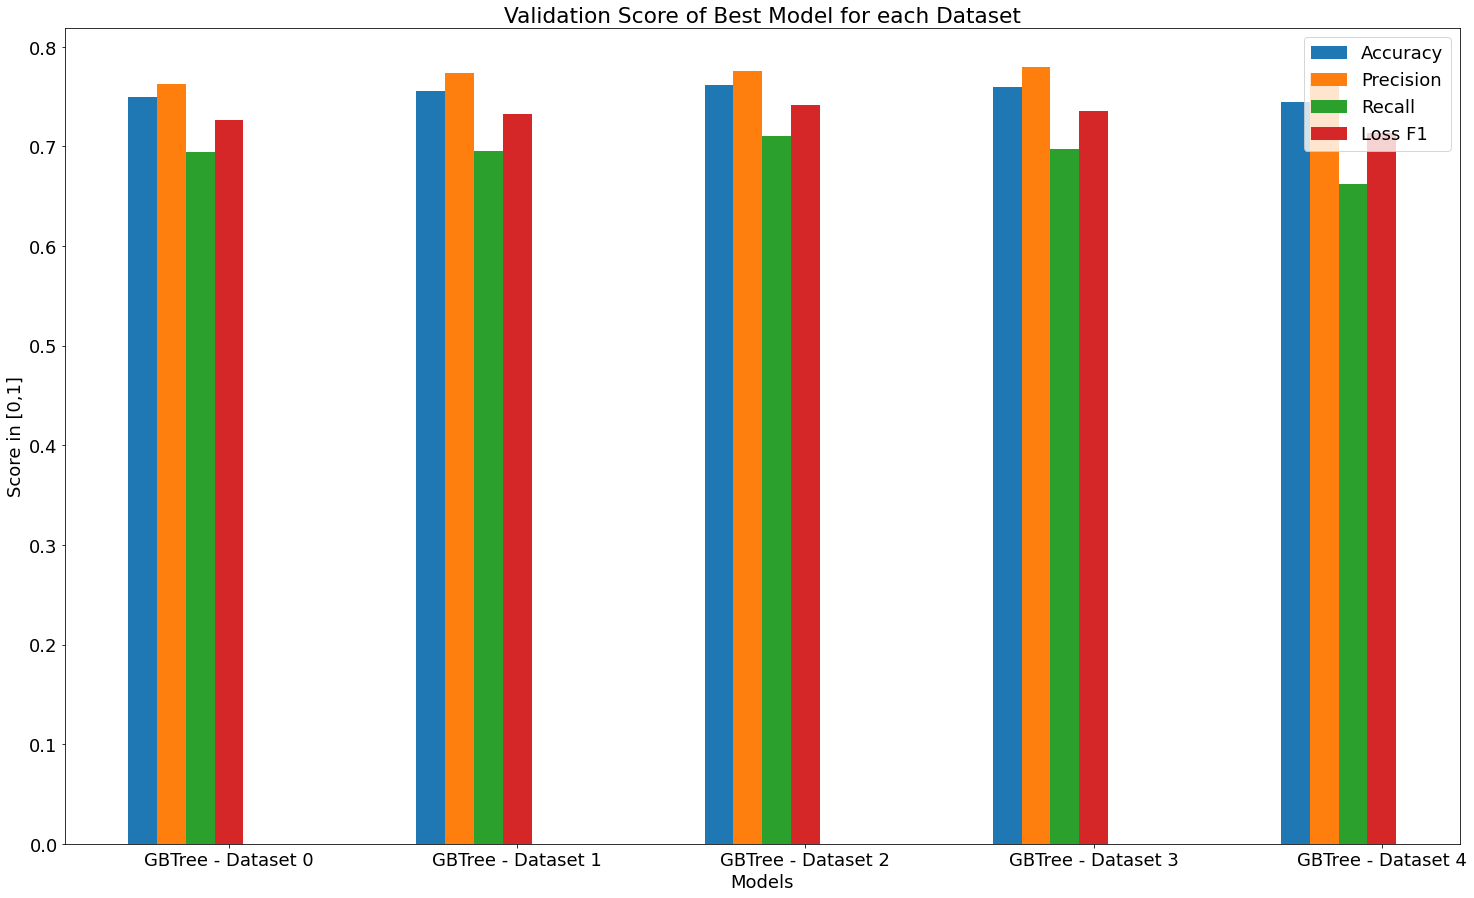

[Info] Dataset with 3 features
.
[Result] The Best GBTree has depth: 3
[Result] Validation Set: Accuracy: 0.738, Precision: 0.754, Recall: 0.678, F1: 0.713

[Info] Dataset with 5 features
.
[Result] The Best GBTree has depth: 3
[Result] Validation Set: Accuracy: 0.749, Precision: 0.763, Recall: 0.693, F1: 0.725

[Info] Dataset with 9 features
.
[Result] The Best GBTree has depth: 3
[Result] Validation Set: Accuracy: 0.759, Precision: 0.772, Recall: 0.709, F1: 0.739

[Info] Dataset with 17 features
.
[Result] The Best GBTree has depth: 3
[Result] Validation Set: Accuracy: 0.753, Precision: 0.766, Recall: 0.701, F1: 0.732

[Info] Dataset with 17 features
.
[Result] The Best GBTree has depth: 3
[Result] Validation Set: Accuracy: 0.735, Precision: 0.764, Recall: 0.653, F1: 0.703



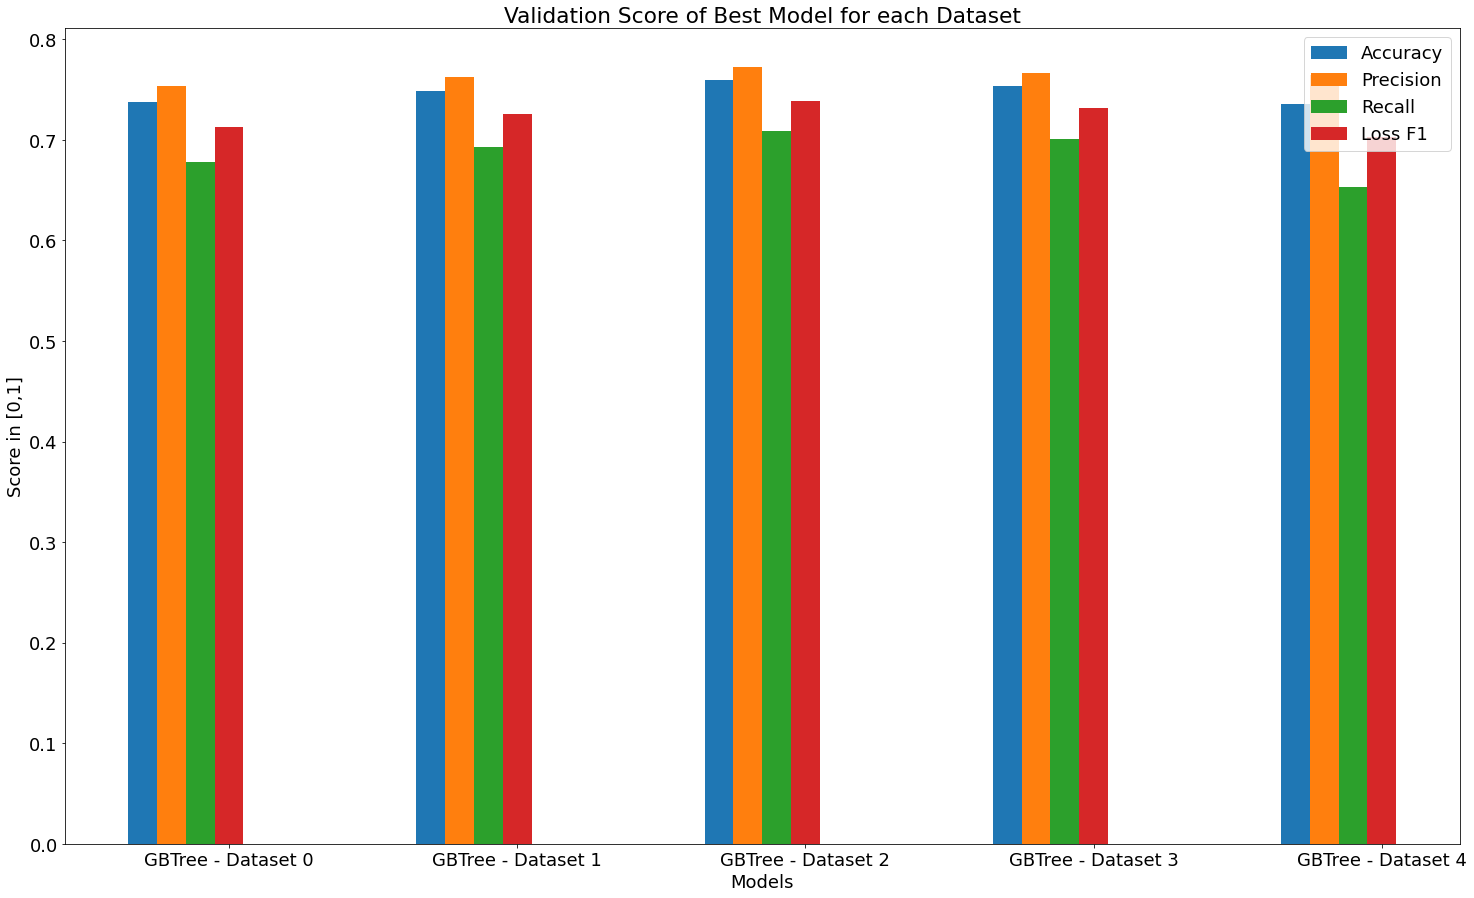

[Info] Dataset with 3 features
.
[Result] The Best GBTree has depth: 3
[Result] Validation Set: Accuracy: 0.744, Precision: 0.755, Recall: 0.691, F1: 0.721

[Info] Dataset with 5 features
.
[Result] The Best GBTree has depth: 3
[Result] Validation Set: Accuracy: 0.750, Precision: 0.760, Recall: 0.697, F1: 0.727

[Info] Dataset with 9 features
.
[Result] The Best GBTree has depth: 3
[Result] Validation Set: Accuracy: 0.774, Precision: 0.796, Recall: 0.713, F1: 0.752

[Info] Dataset with 17 features
.
[Result] The Best GBTree has depth: 3
[Result] Validation Set: Accuracy: 0.767, Precision: 0.782, Recall: 0.711, F1: 0.745

[Info] Dataset with 17 features
.
[Result] The Best GBTree has depth: 3
[Result] Validation Set: Accuracy: 0.742, Precision: 0.767, Recall: 0.662, F1: 0.711



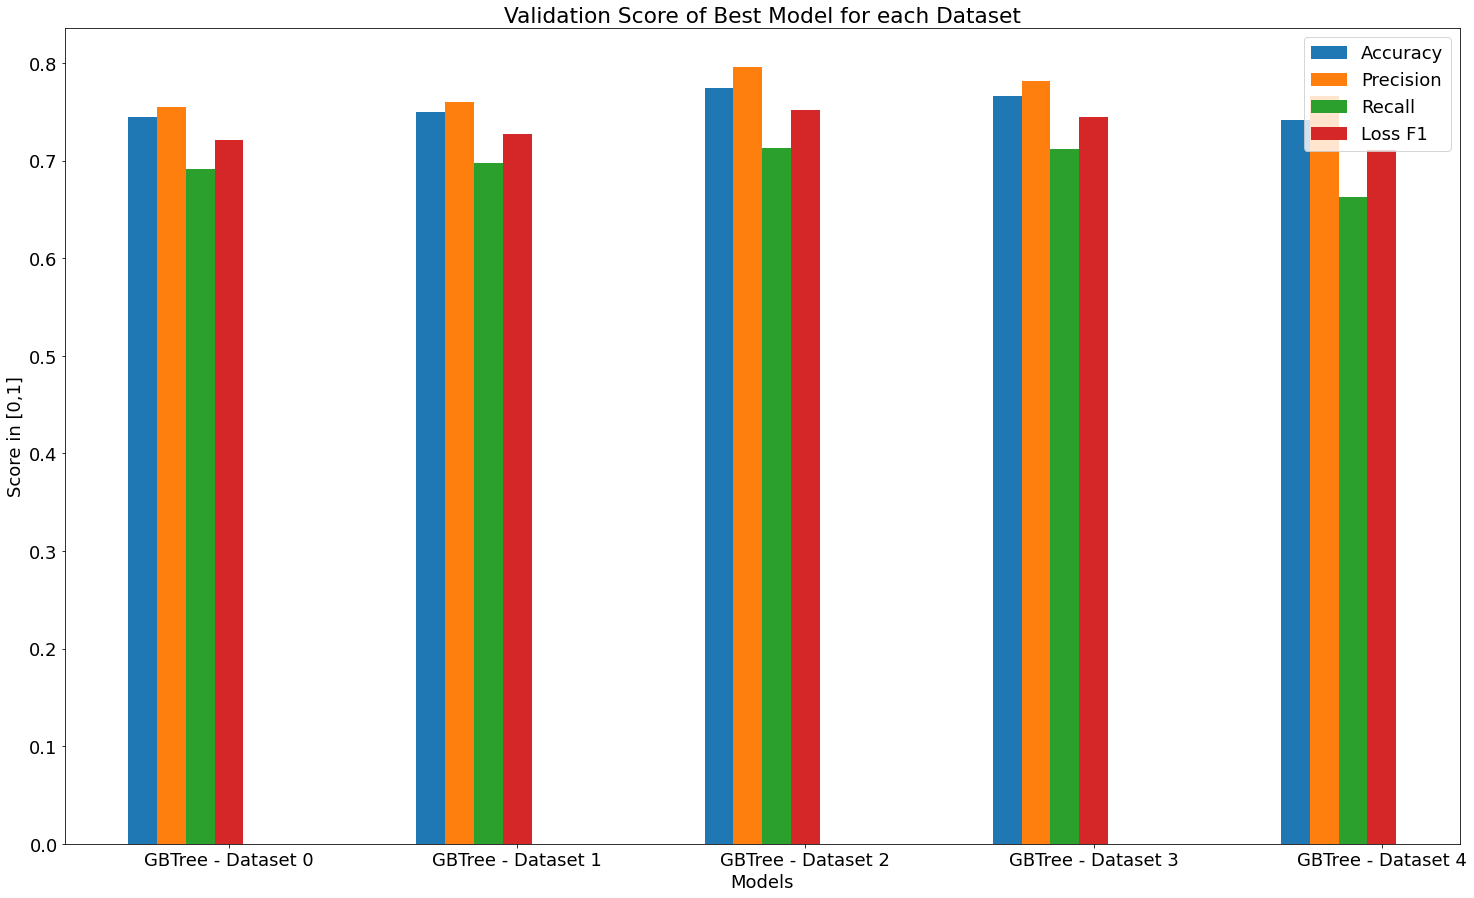

[Info] Dataset with 3 features
.
[Result] The Best GBTree has depth: 3
[Result] Validation Set: Accuracy: 0.743, Precision: 0.750, Recall: 0.702, F1: 0.724

[Info] Dataset with 5 features
.
[Result] The Best GBTree has depth: 3
[Result] Validation Set: Accuracy: 0.753, Precision: 0.766, Recall: 0.701, F1: 0.731

[Info] Dataset with 9 features
.
[Result] The Best GBTree has depth: 3
[Result] Validation Set: Accuracy: 0.773, Precision: 0.792, Recall: 0.716, F1: 0.752

[Info] Dataset with 17 features
.
[Result] The Best GBTree has depth: 3
[Result] Validation Set: Accuracy: 0.766, Precision: 0.785, Recall: 0.705, F1: 0.743

[Info] Dataset with 17 features
.
[Result] The Best GBTree has depth: 3
[Result] Validation Set: Accuracy: 0.744, Precision: 0.778, Recall: 0.653, F1: 0.710



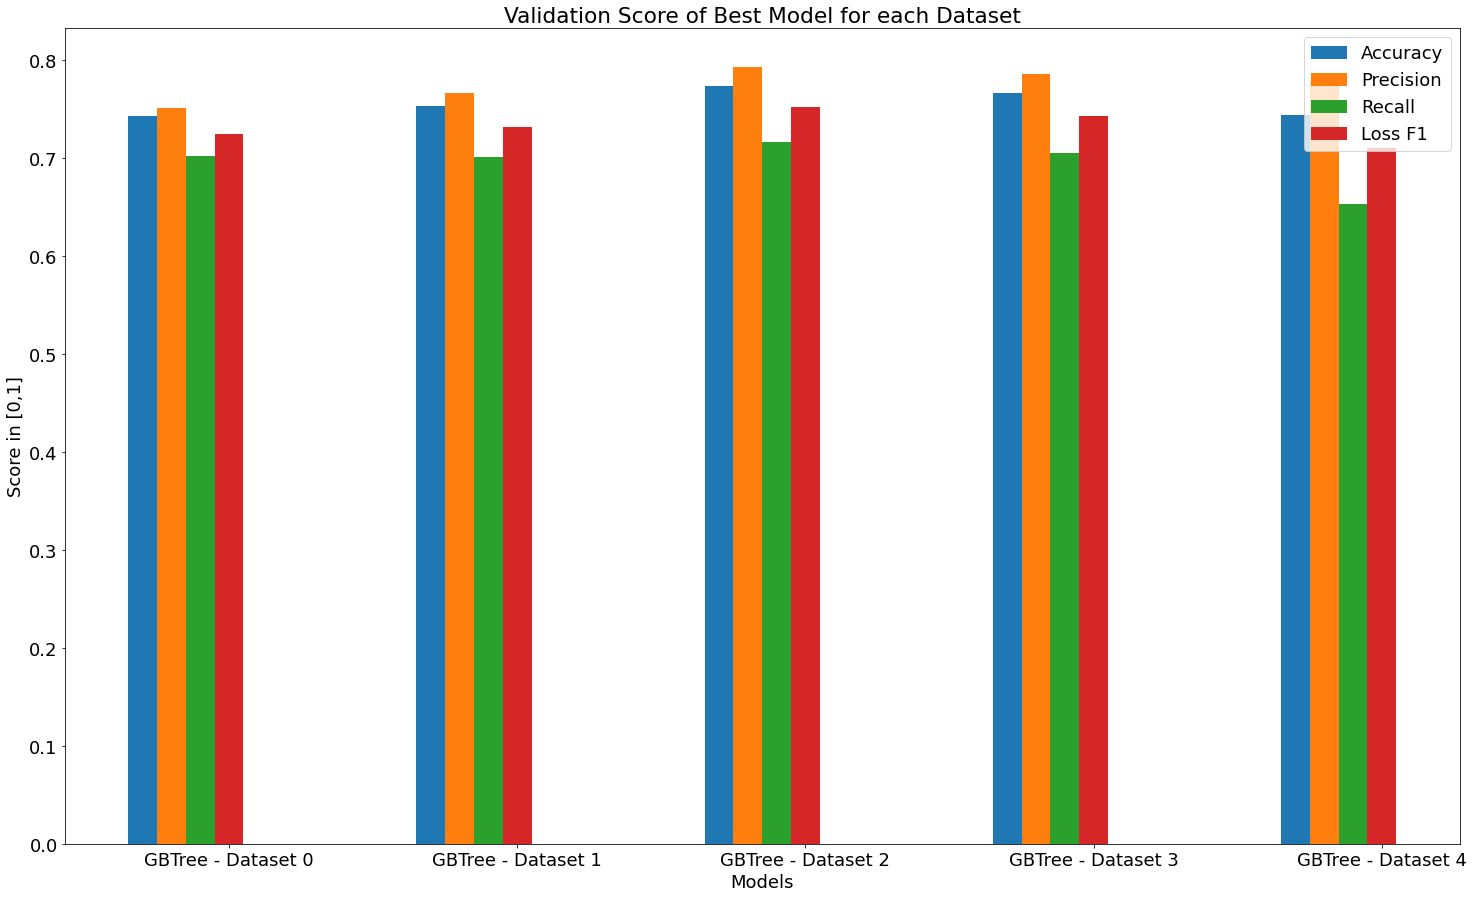

[Info] Dataset with 3 features
.
[Result] The Best GBTree has depth: 3
[Result] Validation Set: Accuracy: 0.744, Precision: 0.759, Recall: 0.685, F1: 0.720

[Info] Dataset with 5 features
.
[Result] The Best GBTree has depth: 3
[Result] Validation Set: Accuracy: 0.758, Precision: 0.774, Recall: 0.700, F1: 0.735

[Info] Dataset with 9 features
.
[Result] The Best GBTree has depth: 3
[Result] Validation Set: Accuracy: 0.766, Precision: 0.783, Recall: 0.709, F1: 0.744

[Info] Dataset with 17 features
.
[Result] The Best GBTree has depth: 3
[Result] Validation Set: Accuracy: 0.767, Precision: 0.787, Recall: 0.705, F1: 0.743

[Info] Dataset with 17 features
.
[Result] The Best GBTree has depth: 3
[Result] Validation Set: Accuracy: 0.743, Precision: 0.771, Recall: 0.662, F1: 0.712



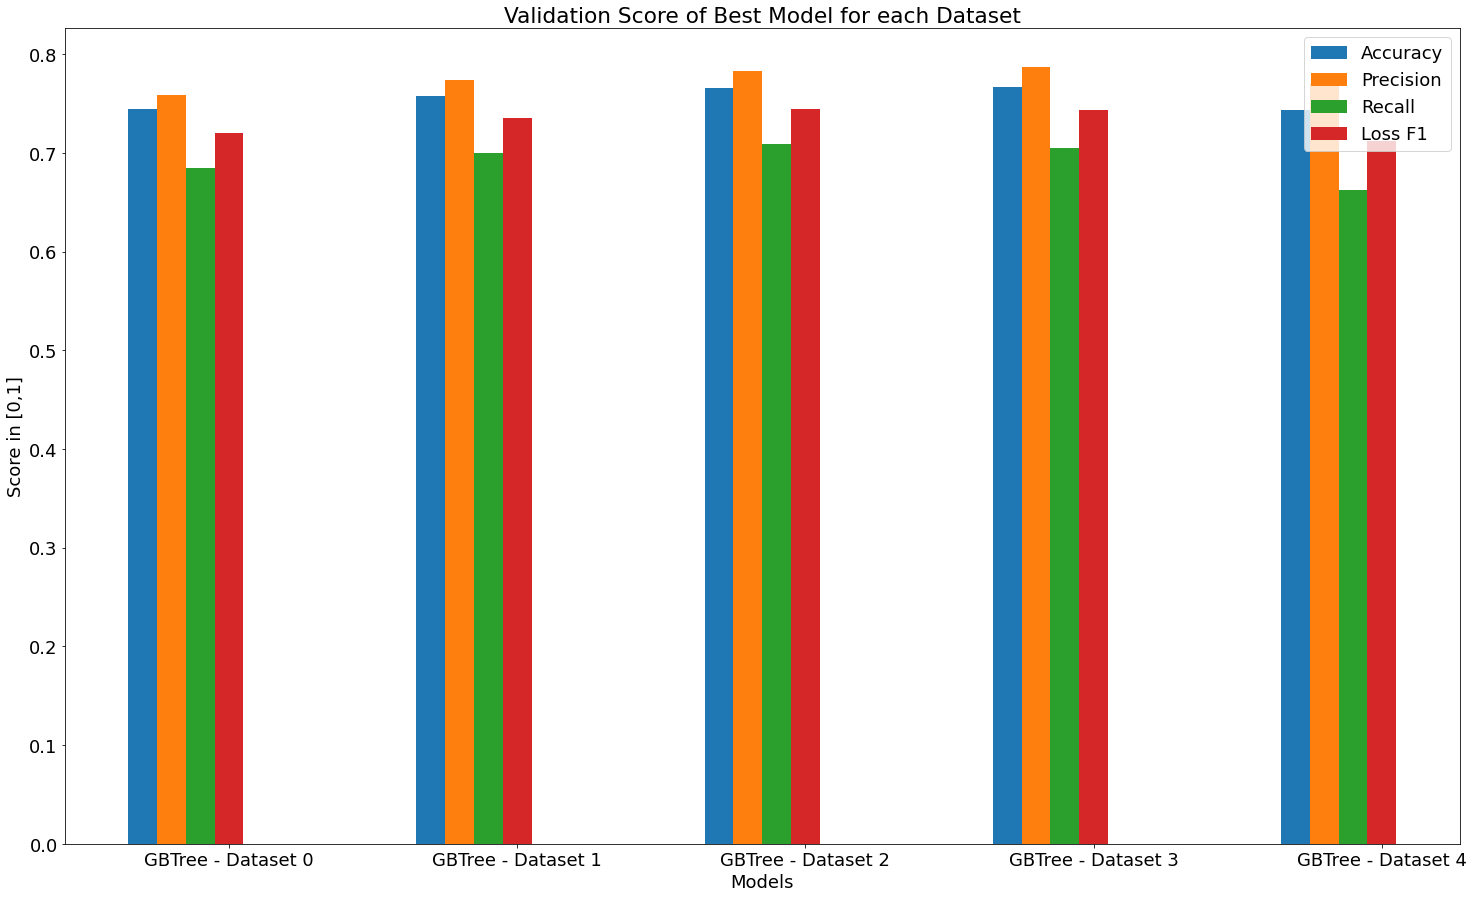

In [163]:
for seed in [0, 1, 2, 3, 4]:
    best_models, val_score_best_models = run_multifeatures_xvalidation_gbt(muons_datasets, ar39_1_datasets, plot_flag=False, rndseed=seed)
    plot_metrics_of_models(val_score_best_models, model_names=["GBTree - Dataset {}".format(i) for i in range(len(muons_datasets))])

## Test models

In [164]:
# prepare test data
skip_first_cols, nslices = 2, 72
muon_test_data = pd.DataFrame(lemuons_cut_test.iloc[:, skip_first_cols:skip_first_cols+nslices].to_numpy())
ar39_test_data = pd.DataFrame(ar39_cut_test.iloc[:, skip_first_cols:skip_first_cols+nslices].to_numpy())
# prepare features
prom_nshiftings = [1, 2, 4]
prom_widths = [72, 54, 36]
muons_test_datasets, ar39_1_test_datasets = produce_datasets_for_various_quandrant_features(muon_test_data, ar39_test_data, prom_nshiftings, prom_widths)

[Info] Computed quadrant features wt nshifting=1, width=72 for Muons
[Info] Computed quadrant features wt nshifting=1, width=72 for Ar39


/home/luigi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/luigi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[Info] Computed quadrant features wt nshifting=2, width=54 for Muons
[Info] Computed quadrant features wt nshifting=2, width=54 for Ar39
[Info] Computed quadrant features wt nshifting=4, width=36 for Muons
[Info] Computed quadrant features wt nshifting=4, width=36 for Ar39


In [165]:
for model, muon_features, ar39_1_features in zip(best_models[:3], muons_test_datasets, ar39_1_test_datasets):
    test_model(muon_features, ar39_1_features, model, "GBTree")

[Info] Dataset with 2 features
[Info] Model: GBTree
[Result] Conf. Matrix: TN: 24503, FP: 4497, FN: 69, TP: 172 | TPR: 71.37%, FPR: 15.51%

[Info] Dataset with 4 features
[Info] Model: GBTree
[Result] Conf. Matrix: TN: 25187, FP: 3813, FN: 74, TP: 167 | TPR: 69.29%, FPR: 13.15%

[Info] Dataset with 8 features
[Info] Model: GBTree
[Result] Conf. Matrix: TN: 25147, FP: 3853, FN: 72, TP: 169 | TPR: 70.12%, FPR: 13.29%



## ML4: DTree tuning directly on all 71 aquisitions

[Info] The Augmented Muon dataset set has 2000 instances
[Info] The Scaled Ar39 dataset has 2077 instances


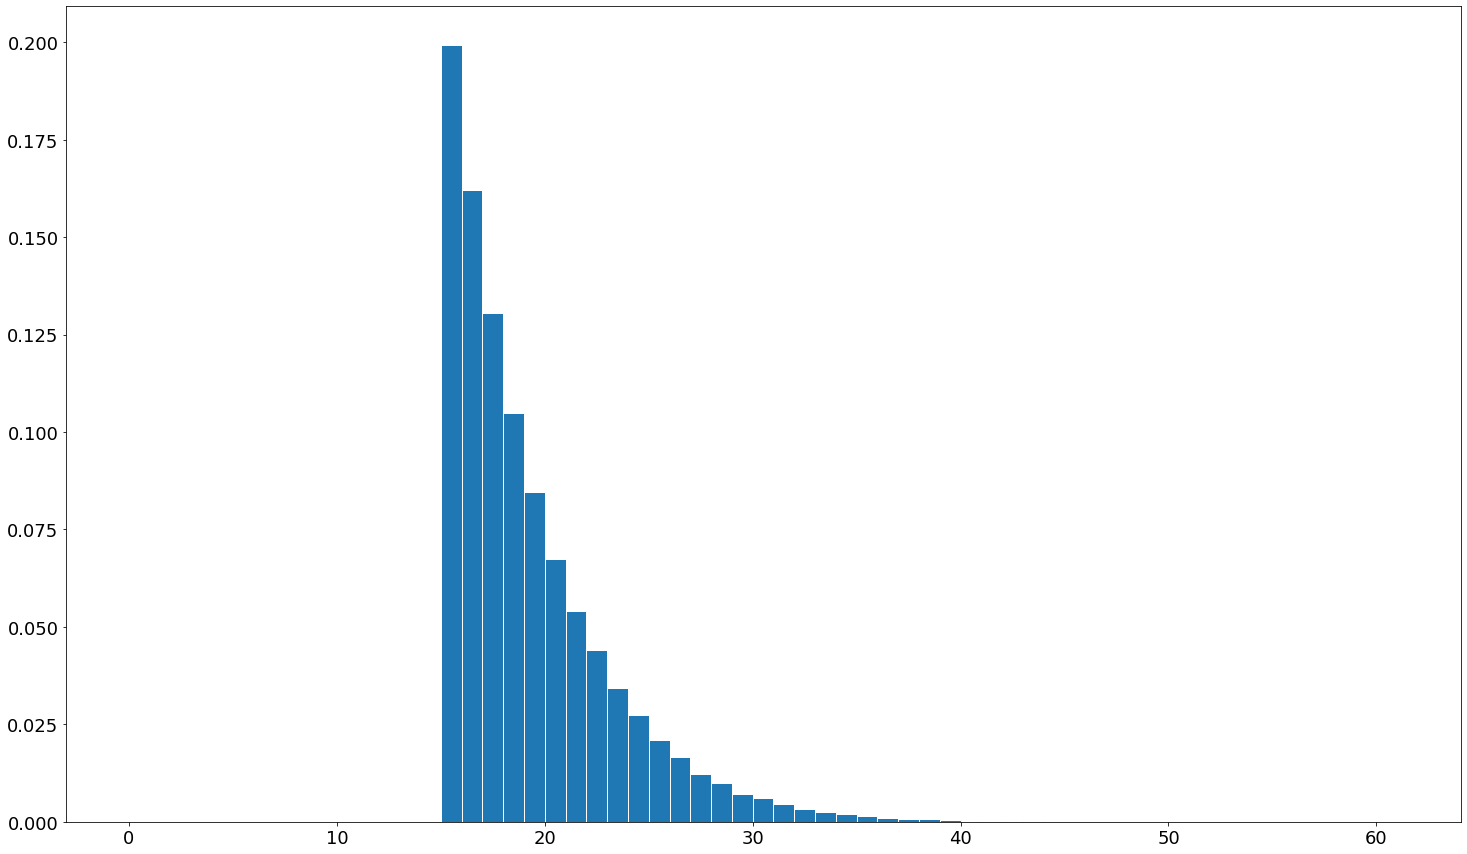

In [166]:
muon_data = augment_muons_by_roll(lemuons_cut_train, augmentation_factor=2)
print("[Info] The Augmented Muon dataset set has {} instances".format(len(muon_data)))
ar39_data = undersample_argon(ar39_cut_train, len(muon_data), augment_from_pe=35, augmentation_nr=5)
print("[Info] The Scaled Ar39 dataset has {} instances".format(len(ar39_data)))

In [170]:
muons_datasets, ar39_1_datasets = [muon_data], [ar39_data]

In [177]:
from sklearn import decomposition
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score

for muon_features, ar39_1_features in zip(muons_datasets, ar39_1_datasets):
    # Prepare data for training
    muon_features["y"] = 1
    ar39_1_features["y"] = 0
    data = pd.concat([muon_features, ar39_1_features], axis=0)
    X, y = data.iloc[:, :-1], data.iloc[:, -1]
    X = np.array(X)
    y = np.array(y)

    # Create an scaler object
    sc = StandardScaler()

    # Create a pca object
    pca = decomposition.PCA()

    decisiontree = DecisionTreeClassifier()

    # Create a pipeline of three steps. First, standardize the data.
    # Second, tranform the data with PCA.
    # Third, train a Decision Tree Classifier on the data.
    pipe = Pipeline(steps=[('sc', sc),
                           ('pca', pca),
                           ('decisiontree', decisiontree)])

    # Create Parameter Space
    # Create a list of a sequence of integers from 1 to 30 (the number of features in X + 1)
    n_components = list(range(1,X.shape[1] + 1, 1))

    # Create lists of parameter for Decision Tree Classifier
    criterion = ['gini', 'entropy']
    max_depth = [4,6,8,12]

    # Create a dictionary of all the parameter options 
    # Note has you can access the parameters of steps of a pipeline by using '__’
    parameters = dict(pca__n_components=n_components,
                      decisiontree__criterion=criterion,
                      decisiontree__max_depth=max_depth)

    # Conduct Parameter Optmization With Pipeline
    # Create a grid search object
    clf = GridSearchCV(pipe, parameters)

    # Fit the grid search
    clf.fit(X, y)

    # View The Best Parameters
    print('Best Criterion:', clf.best_estimator_.get_params()['decisiontree__criterion'])
    print('Best max_depth:', clf.best_estimator_.get_params()['decisiontree__max_depth'])
    print('Best Number Of Components:', clf.best_estimator_.get_params()['pca__n_components'])
    print(); print(clf.best_estimator_.get_params()['decisiontree'])

    # Use Cross Validation To Evaluate Model
    CV_Result = cross_val_score(clf, X, y, cv=4, n_jobs=-1)
    print(); print(CV_Result)
    print(); print(CV_Result.mean())
    print(); print(CV_Result.std())

Best Criterion: gini
Best max_depth: 4
Best Number Of Components: 31

DecisionTreeClassifier(max_depth=4)

[0.79019608 0.80176644 0.73405299 0.41511286]

0.6852820912467048

0.15807084199517074


# ML4: Tune DTree on quad-based features

[Info] The Augmented Muon dataset set has 1000 instances
[Info] The Scaled Ar39 dataset has 1082 instances
[Info] Computed quadrant features wt nshifting=1, width=72 for Muons
[Info] Computed quadrant features wt nshifting=1, width=72 for Ar39


/home/luigi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/luigi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[Info] Computed quadrant features wt nshifting=2, width=54 for Muons
[Info] Computed quadrant features wt nshifting=2, width=54 for Ar39
[Info] Computed quadrant features wt nshifting=4, width=36 for Muons
[Info] Computed quadrant features wt nshifting=4, width=36 for Ar39


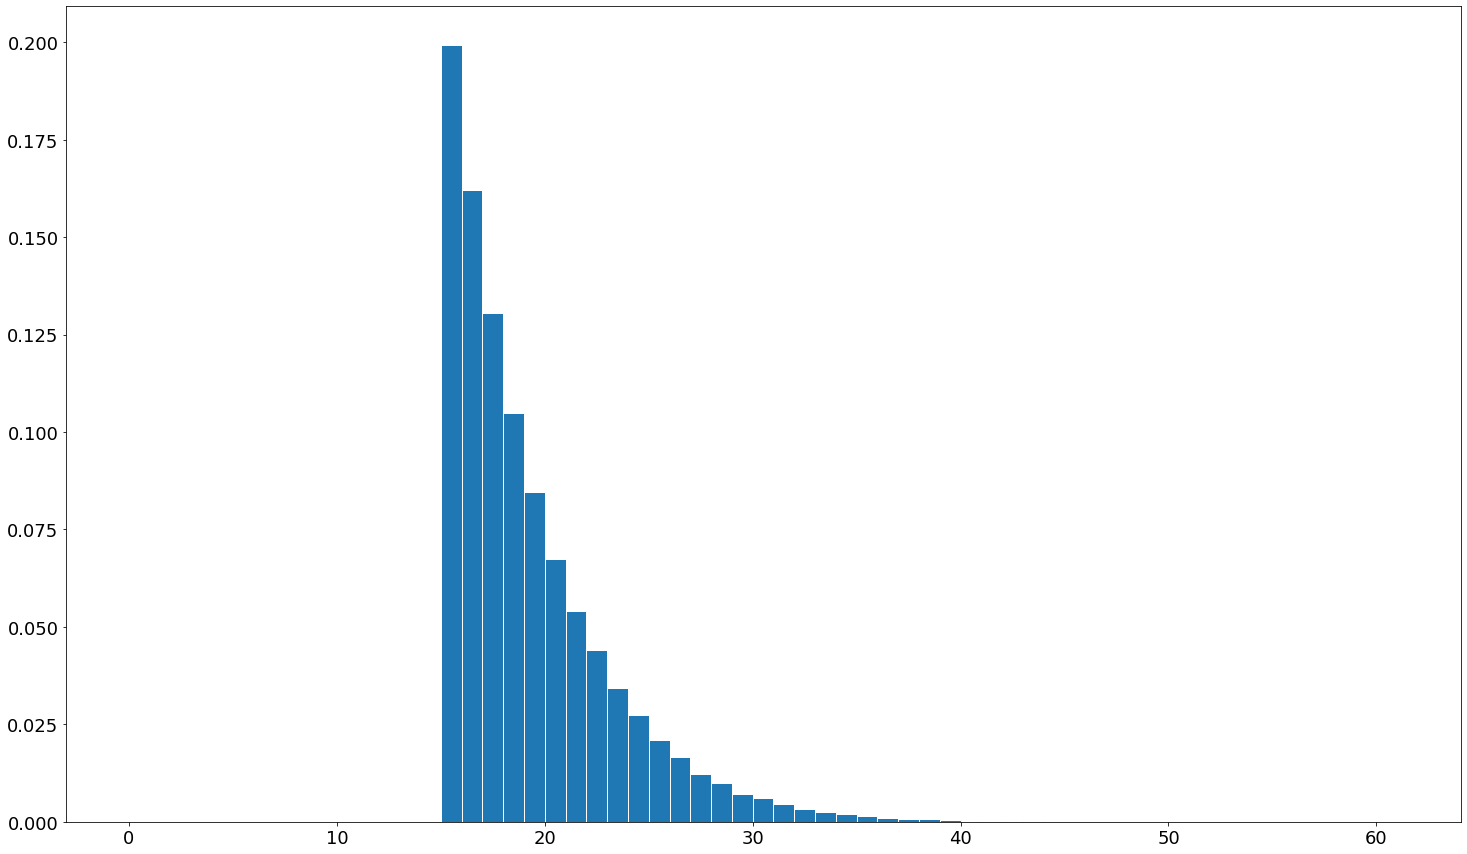

In [201]:
muon_data = augment_muons_by_roll(lemuons_cut_train, augmentation_factor=1)
print("[Info] The Augmented Muon dataset set has {} instances".format(len(muon_data)))
ar39_data = undersample_argon(ar39_cut_train, len(muon_data), augment_from_pe=35, augmentation_nr=5)
print("[Info] The Scaled Ar39 dataset has {} instances".format(len(ar39_data)))

nshiftings = [1, 2, 4]
widths = [72, 54, 36]
muons_datasets, ar39_1_datasets = produce_datasets_for_various_quandrant_features(muon_data, ar39_data, nshiftings, widths)

In [273]:
# in all the datasets -> best n_estimator = 20
muon_features, ar39_1_features = muons_datasets[1], ar39_1_datasets[1]
# Prepare data for training
muon_features["y"] = 1
ar39_1_features["y"] = 0
data = pd.concat([muon_features, ar39_1_features], axis=0)
X, y = data.iloc[:, :-1], data.iloc[:, -1]
X = np.array(X)
y = np.array(y)

# Optimize N Estimators
param_test = {'n_estimators':range(10, 100, 10)}
clf = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, 
                                n_estimators=20, min_samples_leaf=100,
                                max_depth=4, random_state=0), 
                                param_grid = param_test, scoring='precision',
                                n_jobs=2, cv=5)
# Fit the grid search
clf.fit(X, y)
print(clf.best_params_)
print(clf.best_score_)

{'n_estimators': 80}
0.7665198415082843


In [278]:
# Optimize Min Samples Leaf, Max Depth
param_test = {'min_samples_leaf': range(50, 501, 50), 'max_depth': range(2, 7)}
clf = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, 
                                n_estimators=80, random_state=0), 
                                param_grid = param_test, scoring='precision',
                                n_jobs=2, cv=5)
# Fit the grid search
clf.fit(X, y)
print(clf.best_params_)
print(clf.best_score_)

{'max_depth': 3, 'min_samples_leaf': 100}
0.7757304049282616


In [279]:
# Optimize Subsample (stochasticity)
param_test = {'subsample':[0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]}
clf = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,
                                min_samples_leaf=100, max_depth=3,
                                n_estimators=80, random_state=0), 
                                param_grid = param_test, scoring='precision',
                                n_jobs=2, cv=5)
# Fit the grid search
clf.fit(X, y)
print(clf.best_params_)
print(clf.best_score_)

{'subsample': 0.9}
0.772972560035041


In [280]:
# Optimize Learning rate
param_test = {'learning_rate':[0.1, 0.09, 0.08, 0.05]}
clf = GridSearchCV(estimator = GradientBoostingClassifier(subsample=0.9,
                                min_samples_leaf=100, max_depth=3,
                                n_estimators=80, random_state=0), 
                                param_grid = param_test, scoring='precision',
                                n_jobs=2, cv=5)
# Fit the grid search
clf.fit(X, y)
print(clf.best_params_)
print(clf.best_score_)

{'learning_rate': 0.1}
0.772972560035041


In [284]:
tuned_gbt = GradientBoostingClassifier(learning_rate=0.1, subsample=0.9,
                                       min_samples_leaf=100, max_depth=3,
                                       n_estimators=80, random_state=0)
tuned_gbt.fit(X, y)

GradientBoostingClassifier(min_samples_leaf=100, n_estimators=80,
                           random_state=0, subsample=0.9)

In [263]:
# prepare test data
skip_first_cols, nslices = 2, 72
muon_test_data = pd.DataFrame(lemuons_cut_test.iloc[:, skip_first_cols:skip_first_cols+nslices].to_numpy())
ar39_test_data = pd.DataFrame(ar39_cut_test.iloc[:, skip_first_cols:skip_first_cols+nslices].to_numpy())
# prepare features
prom_nshiftings = [2]
prom_widths = [54]
muons_test_datasets, ar39_1_test_datasets = produce_datasets_for_various_quandrant_features(muon_test_data, ar39_test_data, prom_nshiftings, prom_widths)

/home/luigi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/luigi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[Info] Computed quadrant features wt nshifting=2, width=54 for Muons
[Info] Computed quadrant features wt nshifting=2, width=54 for Ar39


In [285]:
for model, muon_features, ar39_1_features in zip([tuned_gbt], muons_test_datasets, ar39_1_test_datasets):
    test_model(muon_features, ar39_1_features, model, "Tuned GBTree")

[Info] Dataset with 5 features
[Info] Model: Tuned GBTree
[Result] Conf. Matrix: TN: 25403, FP: 3597, FN: 66, TP: 175 | TPR: 72.61%, FPR: 12.40%



### Considerations
#### Rejection Ar39
Given `6M` Ar39 aquisitions (*NPE>0*) that represent 98.83% of the background, we perform the following strategy:
1. Reject all the aquisitions with <15 PE. (from `6M` to `138701` Ar39)
1. The aquisitions with >=15PE are given to the GBTree with 4 features (*mean PE, std dev* per 2 quadrants).
Considering its `FPR=12.40%`, it misclassify `138701*.1240=17199` aquisitions.

The resulting trigger rate is `(17199/6309048 * 0.9883 + 0.0117) * 2353 = 34 Hz`.

#### Efficiency
Given `14836` Muons aquisitions (*NPE>0*), we perform the following strategy:
1. Accept all the aquisitions with >60 PE. (accept `10205` instances)
1. Reject all the aquisitions with <15 PE. (loose `3390` instances)
1. The remaining `1241` aquisitions with 15<=PE<=60 are given to the GBTree with 2 features (*mean PE, std dev* per 2 quadrants).
Considering its `TPR=72.61%`, it classify `901` muons and misclassify `340` muons.

The resulting efficiency is `(10205 + 901) / 14836 = 74.86 %`.